# Zeeman slower
This document provides all the information about how to design a Zeeman slower using a magnetic field.
Includes an optional interactive matplotlib widget that lets you vary key parameters with sliders.

## Brief theory introduction

The Zeeman slower is a device used to slow down a beam of atoms using the radiation pressure from a counter-propagating monochromatic laser beam, while compensating for the changing Doppler shift.
Therefore, the laser exerts a force on the atoms, slowing them down over a certain distance with a force, $F_{scatt} = \sigma_{abs} I/c = \hbar k R_{scatt}$, where $\sigma_{abs}$ is the absorption cross-section, $I$ is the laser intensity, $c$ is the speed of light, $\hbar$ is the reduced Planck constant, $k$ is the wavevector of the laser light, and $R_{scatt}$ is the scattering rate $$R_{scatt} = \frac{\Gamma}{2} \frac{\Omega^2/2}{\delta^2+\Omega^2/2+\Gamma^2/4}$$ where $\Gamma$ is the linewidth, $\Omega$ is the Rabi frequency, and $\delta (z) = \omega_L - \omega_0 +kv(z)$ is the detuning where $\omega$ is the laser frequency, $\omega_0$ is the atomic transition frequency, and $kv(z)$ is the Doppler shift.
We can also define the laser detuning at rest as $\delta_0 = \omega_L - \omega_0$ such that the detuning becomes $\delta (z) = \delta_0 +kv(z)$.

Defining the saturation parameter as $s = I/I_{sat} = 2 \Omega^2/\Gamma^2$, where $I_{sat}$ is the saturation intensity, we can rewrite the scattering force as:$$F_{scatt} = \hbar k \frac{\Gamma}{2} \frac{s}{1+s+4(\delta/\Gamma)^2}.$$

When the intensity tends to infinity ($s \gg 1$) and the detuning is zero ($\delta = 0$), the scattering rate reaches its maximum value of $R_{scatt,max} = \Gamma/2$, leading to a maximum deceleration of the atoms given by:
$$a_{max} = \frac{F_{scatt,max}}{m} = \frac{\hbar k}{m} \frac{\Gamma}{2} = \frac{v_r}{2\tau}$$
where $m$ is the mass of the atom, $v_r = \hbar k / m$ is the recoil velocity, and $\tau$ is the excited state lifetime.

### Species properties and constants
Here we define relevant properties (mass, wavelength and linewidth) of several common atomic species used for laser cooling.
Such that we can use their linewidth to study in first instance the range where the scattering rate is significant for different saturation parameters.
We also define some useful constants and import necessary libraries.

In [1]:
%matplotlib inline

# Imports and setup
import math
import wave
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import ipywidgets as w
from IPython.display import display, clear_output

# Physical constants (SI units)
hh = 6.62607015e-34  # J*s (Planck's constant)
hbar = hh / (2.0 * math.pi)
mu_B = 9.274009994e-24  # J/T (Bohr magneton)
amu = 1.66053906660e-27  # kg (atomic mass unit)

# Species dropdown with mass, wavelength (m), gamma (rad/s), and saturation intensity (mW/cm^2)
species_data = {
    'Ca-40':   {'mass': 40.078,  'wavelength': 422.67276e-9, 'gamma': 2 * math.pi * 34.6e6, 'sat_intensity': 60.0},
    'Sr-88':   {'mass': 87.62,   'wavelength': 460.862e-9,    'gamma': 2 * math.pi * 32.0e6},
    'Rb-87':   {'mass': 86.909,  'wavelength': 780.241e-9,    'gamma': 2 * math.pi * 6.065e6},
    'Cs-133':  {'mass': 132.905, 'wavelength': 852.347e-9,    'gamma': 2 * math.pi * 5.234e6},
    'Na-23':   {'mass': 22.990,  'wavelength': 589.158e-9,    'gamma': 2 * math.pi * 9.79e6},
    'Yb-174':  {'mass': 173.045, 'wavelength': 398.911e-9,    'gamma': 2 * math.pi * 29.0e6},
}

# Dropdown = an interactive ipywidgets selection control that lets the user pick
# exactly one option from a list. Its current selection is available as `species.value`
# and is used in later cells to look up `species_data[species.value]` and refresh plots.
# Changing this widget will trigger observers (attached later in the notebook) to
# recompute figures and labels for the chosen atom.
species = w.Dropdown(
    description='Species',
    options=list(species_data.keys()),
    value='Ca-40'
)

# If the interactive widgets already exist, refresh them so display labels
# pick up any newly edited parameter values (e.g., gamma).
for refresh_func_name in ("refresh_simple", "refresh_advanced"):
    refresh_callable = globals().get(refresh_func_name)
    if callable(refresh_callable):
        try:
            refresh_callable()
        except Exception as exc:
            print(f"Warning: {refresh_func_name} failed to refresh ({exc})")

### Scattering rate

Here we define a function that calculates the scattering rate, $R_{scatt}$, as a function of detuning, $\delta$, and saturation parameter, $s$, to study its dependence around zero detuning within the range of Ca linewidth approximately (as an order of magnitude).
It shows that for a given detuning, increasing the saturation parameter increases the scattering rate until a limit of $\Gamma / 2$; the larger the detuning, the more $s$ it takes to reach the limit of the scattering rate.
For a given saturation parameter, the scattering rate peaks at zero detuning and it is symmetric for positive and negative detuning; the larger saturation parameter, the broader and peak closer to $\Gamma / 2$.

In [2]:
# Visualize how the scattering rate depends on saturation parameter and detuning
def scattering_rate(s_param, delta, gamma):
    return 0.5 * gamma * (s_param / (1.0 + s_param + 4.0 * (delta / gamma) ** 2))
# Get current species parameters
current_species = species_data[species.value]
gamma_val = current_species["gamma"]
# Prepare data for plotting
s_values = np.logspace(-2, 3, 400)
detuning_values = np.linspace(-4 * gamma_val, 4 * gamma_val, 600)
# Sample values for plotting
detuning_samples = [0.0, 0.5 * gamma_val, 1.0 * gamma_val, 2.0 * gamma_val]
saturation_samples = [0.05, 0.2, 1.0, 5.0, 20.0, 100.0]

# Widgets for eta target and report label
target_eta_slider = w.FloatSlider(
    description="η target",
    value=0.75,
    min=0.4,
    max=0.95,
    step=0.01,
    readout_format=".2f",
    continuous_update=False,
)
eta_report_label = w.HTML(value="")

def render_scattering_plots(target_eta):
    rates_vs_s = {delta: scattering_rate(s_values, delta, gamma_val) for delta in detuning_samples}
    rates_vs_delta = {s: scattering_rate(s, detuning_values, gamma_val) for s in saturation_samples}

    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 4.5))
    # Left plot: eta vs s for different detunings
    thresholds = []
    # Calculate saturation parameter thresholds for target eta at each detuning
    threshold_map = {}
    for delta, rates in rates_vs_s.items():
        eta_norm = rates / (gamma_val / 2)
        label = f"$\\delta$ = 2$\\pi$ {delta / (2 * math.pi * 1e6):.1f} MHz"
        ax_left.plot(s_values, eta_norm, label=label)
        mask = eta_norm >= target_eta
        if np.any(mask):
            idx = np.argmax(mask)
            if idx == 0:
                s_thresh = s_values[0]
            else:
                y0, y1 = eta_norm[idx - 1], eta_norm[idx]
                x0, x1 = s_values[idx - 1], s_values[idx]
                if y1 != y0:
                    s_thresh = np.interp(target_eta, [y0, y1], [x0, x1])
                else:
                    s_thresh = x1
            thresholds.append(s_thresh)
            threshold_map[delta] = s_thresh
            ax_left.scatter(s_thresh, target_eta, color="black", s=25, zorder=15)
        else:
            thresholds.append(np.nan)
            threshold_map[delta] = float("nan")

    # Plot target eta line and shaded region
    ax_left.axhline(target_eta, color="tab:red", linestyle="--", linewidth=1.2, label=f"$\\eta$ = {target_eta:.2f}")
    s_delta0 = threshold_map.get(0.0, float("nan"))
    # Plot vertical line and shaded region if threshold exists at delta = 0
    if math.isfinite(s_delta0):
        ax_left.axvline(s_delta0, color="tab:red", linestyle=":", linewidth=1.2)
        x_shade = np.logspace(np.log10(s_delta0), np.log10(s_values[-1]), 200)
        ax_left.fill_between(
            x_shade,
            target_eta,
            1.0,
            facecolor="tab:red",
            alpha=0.08,
            label="s meeting $\\eta$ ≥ target",
        )
    ax_left.set_xscale("log")
    ax_left.set_xlabel("Saturation parameter s")
    ax_left.set_ylabel("$\\eta$ = R_scatt / ($\\Gamma$/2)")
    ax_left.set_xlim(1e-2, 1e3)
    ax_left.set_ylim(0.0, 1.05)
    ax_left.legend(loc="lower right", fontsize=8)
    ax_left.grid(True, which="both", ls=":", alpha=0.5)

    # Right plot: eta vs detuning for different saturation parameters
    for s_val, rates in rates_vs_delta.items():
        eta_norm = rates / (gamma_val / 2)
        label = f"s = {s_val:.2f}" if s_val < 10 else f"s = {s_val:.0f}"
        ax_right.plot(detuning_values / (2 * math.pi * 1e6), eta_norm, label=label)

    ax_right.axhline(target_eta, color="tab:red", linestyle="--", linewidth=1.2)
    ax_right.axhspan(
        target_eta,
        1.0,
        facecolor="tab:red",
        alpha=0.08,
        label="$\\eta$ ≥ target",
    )
    ax_right.set_ylim(0.0, 1.05)
    ax_right.set_xlabel("Detuning $\\delta$ / (2$\\pi$·MHz)")
    ax_right.set_ylabel("$\\eta$ = R_scatt / ($\\Gamma$/2)")
    ax_right.legend(loc="upper right", fontsize=8)
    ax_right.grid(True, ls=":", alpha=0.5)

    plt.tight_layout()
    plt.show()

    # Update report label
    if math.isfinite(s_delta0):
        eta_report_label.value = (
            f"<b>s at δ = 0 meeting η = {target_eta:.2f}:</b> {s_delta0:.3f}"
        )
    else:
        eta_report_label.value = (
            f"<span style='color:red'><b>No s in plotted range reaches η = {target_eta:.2f} at δ = 0.</b></span>"
        )

plot_output = w.interactive_output(
    render_scattering_plots, {"target_eta": target_eta_slider}
)

display(w.VBox([target_eta_slider, eta_report_label]), plot_output)

Output()

*Note for the left-side plot*: What we are plotting here is the scattering rate normalized to the maximum scattering rate, i.e., $R_{scatt} / R_{scatt,max}$ which we can define as a quantity $\eta$.
This is of great relevance for the Zeeman slower as setting the eta we will work, sets the deceleration we will apply to the atoms.
Therefore, the **length of the Zeeman slower** and the magnetic field profile will depend on the chosen eta, and the **minimum $s$ such that the ZS will work**.

So, the shorter the Zeeman slower we want, the higher the eta we need, and therefore the higher the saturation parameter we will need to achieve that eta at the maximum detuning (i.e., at the maximum velocity we want to slow down).

The detuning that we apply on the laser from the ideal one at rest, $\delta_0$, will also affect the effective eta we will have at different points of the Zeeman slower, as the detuning will not be zero at all points.
Plus, this range might not be in the MHz range but in the GHz range for fast atomic beams, so the detuning effect will be more significant. 

### Velocity and magnetic field profiles

Here, we assume we are slowing down atoms at a constant deceleration using a counter-propagating laser beam at a rate $\frac{dv}{dt} = v \frac{dv}{dz} = - a$, and when we integrate over position we get the velocity profile as a function of position. Assuming constant deceleration, we can express the velocity as a function of position z along the slower as:
$$v(z) = \sqrt{v_0^2 - 2 a z}$$
where $v_0 = v(z=0)$ is the initial velocity of the atoms at the entrance of the slower, and $a$ is the constant deceleration which is usually expressed $a=\eta a_{max}$ where $\eta \in [0,1]$ is typically between 0.5 and 0.8 to give some margin compared to the maximum deceleration.
Thus, the stopping distance L required to slow atoms from initial velocity $v_0$ to final velocity $v_f = v(z=L)$ is given by:
$$L = \frac{v_0^2 - v_f^2}{2 \eta a_{max}}$$
such that we can express the velocity profile:
$$v(z) = \sqrt{v_0^2 - \left(v_0^2 - v_f^2\right)\frac{z}{L}}$$

Assuming $v_f=0$, $L = \frac{v_0^2}{2 \eta a_{max}}$ and $v(z) = v_0 \sqrt{1 - \frac{z}{L}}$.

When a beam of particles is slowed down using a counter-propagating laser beam, the particles experience a changing Doppler shift, $k v(z)$, as they decelerate.
To maintain resonance between the laser frequency and the atomic transition, a spatially varying magnetic field, $B(z)$, is applied along the length of the slower (or a chirped laser $\omega_L (z)$).

This magnetic field induces a Zeeman shift in the atomic energy levels, compensating for the changing Doppler shift.
$$\omega_0 \pm \frac{\mu B(z)}{\hbar} = \omega_L + k v(z)$$
where $\omega_0$ is the atomic transition frequency, $\omega_L$ is the laser frequency, $\mu_B$ is the Bohr magneton while $\mu = g_{eff} \mu_B$ where $g_{eff}$ is the effective Landé g-factor, and $v(z)$ is the velocity of the atoms at position z.

Hence, the ideal magnetic field profile for a Zeeman slower that maintains resonance throughout the slowing process until $v_f = 0$ via decreasing the field (+sign and $\sigma^+$ polarization) is given by:
$$B_+(z) = B_{bias,+} + B_0\sqrt{1-\frac{z}{L}}$$
where $B_0 = \frac{\hbar k v_0}{\mu} = \frac{h v_0}{\lambda \mu}$ is the maximum magnetic field strength at the entrance of the slower, and $B_{bias,+}$ is a constant offset magnetic field, such that $\mu B_{bias,+} = \hbar \delta_0$ where $\delta_0 = \omega_L - \omega_0$ is the detuning of the laser frequency from the atomic transition frequency.

Whereas the decreasing-field Zeeman slower (-sign and $\sigma^-$ polarization) is for a general final velocity $v_f$,
$$B_-(z) = B_{bias,-} + B_0\left(1-\sqrt{1-\frac{v_0^2 - v_f^2}{v_0^2}\frac{z}{L}}\right)$$
where $B_{bias,-}$ is a constant offset magnetic field, such that $\mu (B_{bias,-} + B_0)= - \hbar \delta_0$.

In case of need to look for more spectral lines, please refer to: https://physics.nist.gov/PhysRefData/ASD/lines_form.html

Or atoms information Safranova 
https://www1.udel.edu/atom

## Increasing-field Zeeman slower study

The following code aims to study the increasing-field Zeeman slower for a general final velocity $v_f$.
The key parameters that can be adjusted are the initial velocity $v_0$, final velocity $v_f$, and slowing efficiency $\eta$, which will mainly determine the length of the Zeeman slower, $L = \frac{v_0^2 - v_f^2}{2 \eta a_{max}}$, together with the atom species to be slowed, which has a certain mass $m$, linewidth $\gamma$, and wavelength $\lambda$ that set the $a_{max} = \frac{h}{m \lambda} \frac{\Gamma}{2}$; and the magnetic field profile, $B_-(z)$, which is also affected by the effective Landé g-factor $g_{eff}$ of the transition and the bias magnetic field, $B_{bias}$, which will also affect the laser detuning needed, $\delta_0$.

The distance from the oven to the Zeeman slower is fixed due to experimental constraints, which is 156 mm, the tube where the Zeeman slower is mounted is 300 mm, and the distance between the end of this tube and the deflectometer is 53 mm, which is the last position where the laser overlaps the atomic beam.

In [3]:
# Clean up previous UI instances to prevent stacked displays when this cell is re-run
for _widget_name in ("_advanced_ui", "_advanced_output"):
    # Widgets stick around across executions; closing avoids duplicated plots/controls.
    _existing_widget = globals().get(_widget_name)
    if _existing_widget is not None:
        try:
            _existing_widget.close()
        except Exception:
            pass

def plot_profile(z_plt, v_plt, B_plt, L_plt):
    """
    Plot Zeeman-slower magnetic field and velocity versus position.

    Parameters
    - z_plt (array-like): Positions along the slower [m]. Must be the same length as v_plt and B_plt.
    - v_plt (array-like): Velocity profile v(z) [m/s].
    - B_plt (array-like): Magnetic-field profile B(z) [T]. Converted to Gauss (×1e4) for display.
    - L_plt (float): Slower length [m]. Used for the plot title only.

    Behavior
    - Produces a matplotlib figure with two y-axes sharing z:
      left axis: B(z) in Gauss; right axis: v(z) in m/s.
    - Uses NaN-safe maxima to set y-limits and adds a small negative margin.
    - Applies grid and tight layout, then displays the figure. Returns None.

    Notes
    - NaN values are ignored for axis scaling.
    - If arrays are empty, minimal nonzero limits are used to avoid errors.
    - Inputs are not modified.
    """
    fig, ax1 = plt.subplots(figsize=(7, 4))
    ax1.set_xlabel("z (m)")
    ax1.set_ylabel("B (G)", color="tab:blue")
    ax1.plot(z_plt, B_plt * 1e4, color="tab:blue", lw=2, label="B(z) [G]")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True, ls="--", alpha=0.4)
    ax2 = ax1.twinx()
    ax2.set_ylabel("v (m/s)", color="tab:orange")
    ax2.plot(z_plt, v_plt, color="tab:orange", lw=2, label="v(z) [m/s]")
    ax2.tick_params(axis="y", labelcolor="tab:orange")
    max_B = np.nanmax(B_plt * 1e4) if np.size(B_plt) else 1.0
    max_v = np.nanmax(v_plt) if np.size(v_plt) else 1.0
    max_B = max(1e-8, max_B) * 1.05
    max_v = max(1e-8, max_v) * 1.05
    ax1.set_ylim(-0.05 * max_B, max_B)
    ax2.set_ylim(-0.05 * max_v, max_v)
    ax1.set_title(f"Zeeman slower profile (L = {L_plt*100:.2f} cm)")
    plt.tight_layout()
    plt.show()

def compute_B_z_forces(mass_amu=40.078, wavelength=422.67276e-9, gamma=2*math.pi*34.6e6, g_eff=1.0,
                    v0=500.0, vf=50.0, B_bias=250, eta=0.5, n_points=500):
    """
    Compute the 1D Zeeman-slower magnetic-field and velocity profiles for an
    increasing-field design assuming constant deceleration a = eta * a_max,
    where a_max = (ħ k γ / 2) / m.

    Parameters
    - mass_amu (float): Atomic mass in atomic mass units [amu].
    - wavelength (float): Transition wavelength [m].
    - gamma (float): Natural linewidth Γ, angular frequency [rad/s].
    - g_eff (float): Effective magnetic g-factor (dimensionless).
    - v0 (float): Entrance velocity (capture velocity) [m/s].
    - vf (float): Exit velocity (final velocity) [m/s].
    - B_bias (float): Entrance bias field in Gauss.
    - eta (float): Fraction of the maximum scattering force (0 < eta ≤ 1).
    - n_points (int): Number of samples along z inside the slower.

    Returns
    - z (ndarray): Positions along the slower [m], from 0 to L.
    - v (ndarray): Velocity profile v(z) [m/s].
    - B (ndarray): Magnetic-field profile B(z) [T].
    - L (float): Slower length [m].
    - diagnostics (dict): Additional scalars:
        * F_max [N]     : Maximum scattering force (s → ∞).
        * a_max [m/s^2] : Maximum deceleration = F_max / m.
        * a [m/s^2]     : Chosen deceleration = eta * a_max.
        * B_delta [T]   : Scale field = ħ k v0 / (μ_B g_eff).
        * delta_ideal   : Design detuning (angular) for z=0 resonance [rad/s].

    Notes
    - B_bias is provided in Gauss; the returned B(z) is in Tesla (multiply by 1e4 to get Gauss).
    - Raises ValueError if the computed deceleration is non-positive or if v0 ≤ vf.
    - Uses the standard increasing-field Zeeman-slower profile:
        v(z) = sqrt(v0^2 - (v0^2 - vf^2) * z / L)
        B(z) = B_bias_T + B_delta * (1 - sqrt(1 - ((v0^2 - vf^2)/v0^2) * (z / L)))
      with L = (v0^2 - vf^2) / (2 a) and B_delta = ħ k v0 / (μ_B g_eff).
    """
    mm = mass_amu * amu     # Convert mass from amu to kg
    kk = 2 * math.pi / wavelength   # Wave number k [1/m]
    F_max = hbar * kk * gamma / 2.0  # Max scattering force [N]
    a_max = F_max / mm      # Max deceleration [m/s^2]
    aa = eta * a_max        # Chosen deceleration [m/s^2]
    # Input validation
    if aa <= 0:
        raise ValueError("Computed deceleration <= 0; check s0 and eta")
    if v0 <= vf:
        raise ValueError("Initial velocity v0 must be > final velocity vf")
    # Ideal-length and magnetic profile for the increasing-field design.
    LL = (v0 * v0 - vf * vf) / (2.0 * aa)       # Slower length [m]
    B_delta = hbar * kk / (mu_B * g_eff) * v0     # Scale field [T]
    B_bias_T = B_bias * 1e-4                    # Gauss slider uses CGS units → Tesla
    zz = np.linspace(0.0, LL, n_points)          # Positions along the slower [m]
    vv = np.sqrt(v0**2 - (v0**2 - vf**2) * zz / LL)   # Velocity profile [m/s]
    # Magnetic field profile [T]
    BB = B_bias_T + B_delta * (1 - np.sqrt(1 - ((v0**2 - vf**2) / v0**2) * (zz / LL)))
    delta_ideal = - mu_B * g_eff * (B_bias_T + B_delta) / hbar    # Design detuning [rad/s]
    diagnostics = {
        "F_max": F_max,     # Maximum scattering force [N]
        "a_max": a_max,     # Maximum deceleration [m/s^2]
        "a": aa,            # Chosen deceleration [m/s^2]
        "B_delta": B_delta,  # Scale field [T]
        "delta_ideal": delta_ideal,  # Design detuning [rad/s]
    }
    return zz, vv, BB, LL, diagnostics

# Slider definitions (all use continuous_update=False to avoid overwhelming plots).
v0_adv = w.FloatSlider(description="v0 (m/s)", value=1000.0,
                       min=400.0, max=1200.0, step=5.0, continuous_update=False)
vf_adv = w.FloatSlider(description="vf (m/s)", value=50.0,
                       min=0.0, max=100.0, step=5.0, continuous_update=False)
eta_adv = w.FloatSlider(description="eta", value=0.75,
                        min=0.01, max=1.0, step=0.01, continuous_update=False)
B_bias_adv = w.FloatSlider(description="B_bias (G)", value=250.0,
                           min=1.0, max=500.0, step=1.0, continuous_update=False)
g_eff_adv = w.FloatSlider(description="g_eff", value=1.0,
                          min=0, max=2.0, step=0.01, continuous_update=False)
points_adv = w.IntSlider(description="points", value=600,
                         min=50, max=1000, step=50, continuous_update=False)
# Dynamic labels and output container.
wavelength_label_advanced = w.HTML()
gamma_label_advanced = w.HTML()
summary_label_advanced = w.HTML()
out_advanced = w.Output()
# Update wavelength and gamma labels based on selected species.
def update_info_advanced():
    d = species_data[species.value]
    wavelength_label_advanced.value = f"<b>&lambda;</b>: {d['wavelength']*1e9:.3f} nm"
    gamma_label_advanced.value = f"<b>&Gamma;/2&pi;</b>: {d['gamma']/(2*math.pi)/1e6:.3f} MHz"
# Refresh function to recompute and plot the profiles.
def refresh_advanced(change=None):
    d = species_data[species.value]
    update_info_advanced()
    try:
        zz, vv, BB, LL, diag = compute_B_z_forces(
            mass_amu=d['mass'],
            wavelength=d['wavelength'],
            gamma=d['gamma'],  # Use angular frequency
            v0=v0_adv.value,
            vf=vf_adv.value,
            eta=eta_adv.value,
            B_bias=B_bias_adv.value,
            g_eff=g_eff_adv.value,
            n_points=points_adv.value,
        )
    except Exception as exc:
        summary_label_advanced.value = f"<span style='color:red'>Parameter error: {exc}</span>"
        with out_advanced:
            clear_output(wait=True)
            print("Parameter error:", exc)
        return

    # Extend the profile with zero-field, constant-velocity regions before and after the slower.
    L_max = 300e-3          # 30 cm maximum slower length
    pre_length = 156e-3 + (L_max - LL) # fixed 15.6 cm input beam path from oven + remaining length up to L_max
    post_length = 53e-3     # fixed 5.3 cm output beam path + 252e-3 until MOT
    # Estimate density of points to maintain resolution in extended regions.
    base_span = max(zz[-1] - zz[0], 1e-3)
    density = max(points_adv.value - 1, 1) / base_span
    pre_points = max(200, int(math.ceil(pre_length * density)))
    post_points = max(100, int(math.ceil(post_length * density)))
    z_pre = np.linspace(zz[0] - pre_length, zz[0], pre_points + 1)[:-1]
    z_post = np.linspace(zz[-1], zz[-1] + post_length, post_points + 1)[1:]
    # Constant velocity and zero magnetic field in the extended regions.
    B_pre = np.zeros_like(z_pre)
    B_post = np.zeros_like(z_post)
    v_pre = np.full_like(z_pre, vv[0])
    v_post = np.full_like(z_post, vv[-1])
    z_extended = np.concatenate([z_pre, zz, z_post]) if z_pre.size or z_post.size else zz
    B_extended = np.concatenate([B_pre, BB, B_post]) if z_pre.size or z_post.size else BB
    v_extended = np.concatenate([v_pre, vv, v_post]) if z_pre.size or z_post.size else vv

    # Plot within the output widget.
    with out_advanced:
        clear_output(wait=True)
        plot_profile(z_extended, v_extended, B_extended, LL)
    summary_label_advanced.value = (
        f"<b>Slower length</b>: {LL*100:.2f} cm"
        f"<br><b>Max force</b>: {diag['F_max']:.3e} N"
        f"<br><b>Design detuning</b>: {diag['delta_ideal']/(2 * math.pi * 1e9):.2f} &times; 2&pi; GHz"
        f"<br><b>B0</b>: {diag['B_delta']*1e4:.1f} G"
    )
    # Persist the latest profile + metadata so later cells (phase-space) can reuse it.
    globals()["_advanced_state"] = {
        "species": species.value,
        "species_props": dict(d),
        "z": zz,
        "v": vv,
        "B": BB,
        "z_extended": z_extended,
        "v_extended": v_extended,
        "B_extended": B_extended,
        "slower_bounds": (float(zz[0]), float(zz[-1])),
        "L": LL,
        "diagnostics": diag,
        "params": {
            "v0": v0_adv.value,
            "vf": vf_adv.value,
            "eta": eta_adv.value,
            "B_bias": B_bias_adv.value,
            "g_eff": g_eff_adv.value,
            "points": points_adv.value,
        }
    }

# Attach observers to refresh on widget value changes.
_advanced_observers = globals().get("_advanced_observers", [])
for widget, handler in _advanced_observers:
    try:
        widget.unobserve(handler, names='value')
    except Exception:
        pass
_advanced_observers = []
# Attach new observers.
advanced_widgets = (species, v0_adv, vf_adv, eta_adv, B_bias_adv, g_eff_adv, points_adv)
for widget in advanced_widgets:
    widget.observe(refresh_advanced, names='value')
    _advanced_observers.append((widget, refresh_advanced))
# Store observers globally to allow cleanup on re-execution.
ui_advanced = w.VBox([
    w.HBox([species, wavelength_label_advanced, gamma_label_advanced]),
    w.HBox([v0_adv, vf_adv, eta_adv]),
    w.HBox([B_bias_adv, g_eff_adv, points_adv]),
    summary_label_advanced,
])

globals()["_advanced_ui"] = ui_advanced
globals()["_advanced_output"] = out_advanced

refresh_advanced()
display(ui_advanced, out_advanced)

Output()

## Scattering force map and phase-space trajectories

The motion of the atoms in the Zeeman slower can be described by the 1D Newtonian model
$$m \frac{d^2z}{dt^2} = F_{scatt}(z,v) = \hbar k \frac{\Gamma}{2} \frac{s}{1+s+\frac{4 \delta(z,v)^2}{\Gamma^2}}$$
where the scattering force $F_{scatt}(z,v)$ depends on both position and velocity through the detuning $\delta(z,v) = \delta_0 + k v + \mu B(z)/\hbar$ for the increasing field configuration (the decreasing field configuration is analogous with a sign change in the magnetic field term).

The key parameters that can be adjusted are:
- $\delta_0$ shifts the force field map in the velocity axis, up when decreased (so, capture velocity and final velocity increase), and viceversa.
- $s$ increasing it: decreases the actual final velocity, and increases the capture velocity, i.e., the maximum initial velocity that can be slowed down.

In [4]:
# PARAMS AND GUI SETUP
advanced_state = globals().get("_advanced_state")
if not advanced_state:
    raise RuntimeError("Run previous cell (advanced Zeeman slower widget)" \
    "before executing this cell so the magnetic profile is available.")
# Retrieve stored profile and parameters.
species_name = advanced_state["species"]
species_props = advanced_state["species_props"]
spec = dict(species_props)
# Pull the stored species values so this cell mirrors the widget configuration.
wavelength = spec["wavelength"]
gamma = spec["gamma"]
mass = spec["mass"] * amu
sat_in = spec["sat_intensity"] if "sat_intensity" in spec else 60.0
kk = 2 * math.pi / wavelength
# Extract parameters from stored state.
params = advanced_state["params"]
g_eff_val = float(params["g_eff"])
v_capture = float(params["v0"])
v_final = float(params["vf"])
if v_capture <= v_final:
    raise RuntimeError("Stored profile has v0 <= vf." \
    "Rerun cell (adv ZS widget) with valid parameters.")
z_axis_core = np.asarray(advanced_state["z"])
B_profile_core = np.asarray(advanced_state["B"])
z_profile = np.asarray(advanced_state["z_extended"])
B_profile_extended = np.asarray(advanced_state["B_extended"])
L_design = float(advanced_state["L"])
slower_bounds = advanced_state["slower_bounds"]
z_slower_start, z_slower_end = slower_bounds
diag = advanced_state["diagnostics"]
delta_design = float(diag["delta_ideal"])
eta_design = float(params["eta"])
F_max = float(diag["F_max"])
a_max = float(diag["a_max"])
ideal_detuning = float(diag["delta_ideal"])

# Slider controls to explore different scattering intensities and laser detunings around the ideal design.
intensity_slider = w.FloatSlider(description="I (mW/cm²)", value=600.0,
                                 min=10.0, max=2000.0, step=10.0, continuous_update=False)
span_ghz = max(0.5, abs(ideal_detuning / (2 * math.pi * 1e9)) * 0.5)
# Detuning slider (Δ/2π in GHz) centered on the design detuning, with an explanatory tooltip.
detuning_center_ghz = ideal_detuning / (2 * math.pi * 1e9)
detuning_slider = w.FloatSlider(
    description="Δ/2π (GHz)",
    value=detuning_center_ghz,
    min=detuning_center_ghz - span_ghz / 2.0,
    max=detuning_center_ghz + span_ghz / 2.0,
    step=0.005,
    continuous_update=False,
    readout_format=".3f",
)
detuning_slider.tooltip = (
    "Laser detuning from the atomic resonance divided by 2π, expressed in GHz. "
    "Negative values are red-detuned. Range is centered on the design detuning."
)
traj_count_slider = w.IntSlider(description="Traj count", value=12,
                                min=4, max=40, step=1, continuous_update=False)
max_v0_slider = w.FloatSlider(
    description="Max v0 (m/s)",
    value=v_capture * 1.2,
    min=max(1.0, v_final * 0.9),
    max=v_capture * 1.7,
    step=10.0,
    continuous_update=False,
 )
# Info labels
ideal_detuning_label = w.HTML(
    f"<b>Ideal detuning/2&pi;</b>: {detuning_center_ghz:.3f} GHz"
 )
sat_info_label = w.HTML(
    f"<b>Saturation intensity</b>: {sat_in:.1f} mW/cm²<br><b>s</b>: {600.0 / sat_in:.2f} (I/I_sat)"
 )
eta_reference_label = w.HTML("<b>Capture trajectory ⟨&eta;<sub>eff</sub>&rang;</b>: n/a")

# -------------------- FORCE MAP and TRAJECTORIES SIMULATION --------------------
# Sample velocities well below zero so the force map shows deceleration all the way through the stop.
v_min = -0.25 * v_capture
v_max = max_v0_slider.value * 1.05
vel_axis = np.linspace(v_min, v_max, 500)
gray_cmap = ListedColormap(plt.cm.Greys(np.linspace(0.0, 0.85, 256)))

# Precompute quantities for trajectory integration.
z_min, z_max = float(z_profile[0]), float(z_profile[-1])
flight_time = L_design / v_capture
# flight time for the design velocity profile through the slower as an integration of v(z)=dz/dt:
def _inv_velocity(z_rel: float) -> float:
    v_sq = v_capture**2 - (v_capture**2 - v_final**2) * z_rel / L_design
    return 1.0 / math.sqrt(max(v_sq, 1e-12))
flight_time_ideal, _ = integrate.quad(_inv_velocity, 0.0, L_design, limit=200)
# Sanity check on flight time.
if flight_time < 1e-6:
    raise RuntimeError("Unrealistically short flight time through the slower; check v0 and slower length.")
print("Estimated flight time through the slower ct capture vel {:.3f} ms".format(flight_time * 1e3))
print("Estimated flight time (cap vel ideal profile) {:.3f} ms".format(flight_time_ideal * 1e3))
base_dt = flight_time / max(len(z_axis_core) - 1, 1)
base_steps = max(len(z_profile), 2)
min_speed = 1e-4  # m/s to avoid stalling

# Interpolate the magnetic field profile onto a finer z grid for force map rendering.
z_force = np.linspace(z_min, z_max, max(len(z_profile), 800))
B_force = np.interp(z_force, z_profile, B_profile_extended)

# Identify field-free drift regions before and after the slower for plotting visualization.
drift_regions = []
if z_min < z_slower_start:
    drift_regions.append((z_min, z_slower_start))
if z_max > z_slower_end:
    drift_regions.append((z_slower_end, z_max))

def scattering_force_and_eta(delta_laser, B_T, velocities, s_value):
    delta = delta_laser + kk * velocities + g_eff_val * mu_B * B_T / hbar
    denom = 1.0 + s_value + (2.0 * delta / gamma) ** 2
    force = hbar * kk * gamma / 2.0 * (s_value / denom)
    return force, s_value / denom

def integrate_trajectory(v_init, delta_laser, s_value, record_eta=False):
    '''Integrate a single trajectory starting from z_min with initial velocity v_init'''
    # Adjust max steps based on initial speed to ensure adequate resolution
    speed_scale = max(1.0, v_capture / max(abs(v_init), min_speed))
    max_steps = int(math.ceil(base_steps * speed_scale * 8.0))
    # Initialize trajectory lists
    traj_z = [z_min]
    traj_v = [v_init]
    eta_samples = [] if record_eta else None
    # Time-stepping loop
    for _ in range(max_steps):
        # Get current position and velocity
        v_curr = traj_v[-1]
        z_curr = traj_z[-1]
        # Prevent stalling at very low speeds
        if abs(v_curr) < min_speed:
            prev = traj_v[-2] if len(traj_v) > 1 else 1.0
            v_curr = np.copysign(min_speed, prev)
            traj_v[-1] = v_curr
        # Sample magnetic field and compute force
        z_sample = float(np.clip(z_curr, z_min, z_max))
        B_val = np.interp(z_sample, z_profile, B_profile_extended)
        force, eta_point = scattering_force_and_eta(delta_laser, B_val, v_curr, s_value)
        # Update velocity and position using Euler integration
        accel = -force / mass
        v_next = v_curr + accel * base_dt
        z_next = z_curr + v_curr * base_dt
        traj_v.append(v_next)
        traj_z.append(z_next)
        if record_eta:
            eta_samples.append(eta_point)

        # Termination conditions: exit if outside z bounds and moving away
        if (z_next <= z_min and v_next <= 0) or (z_next >= z_max and v_next >= 0):
            break
    if record_eta:
        return np.asarray(traj_z), np.asarray(traj_v), np.asarray(eta_samples)
    return np.asarray(traj_z), np.asarray(traj_v)


def plot_phase_space(intensity_mw_cm2, detuning_ghz, trajectory_count, max_initial_velocity):
    s0_val = intensity_mw_cm2 / sat_in if sat_in else 0.0  # Saturation parameter
    delta_laser = detuning_ghz * 1e9 * 2.0 * math.pi       # Convert GHz to rad/s
    # Compute and update saturation info label.
    eta_ideal_slider = params["eta"]  # Ideal eta from the stored profile
    sat_info_label.value = (
        f"<b>Saturation intensity</b>: {sat_in:.1f} mW/cm²"
        f"<br><b>s</b> = {s0_val:.3f} (I/I_sat)"
        f"<br><b>&eta;<sub>imposed</sub></b>(&delta;=0) = {eta_ideal_slider:.3f}"
    )

    # Generate initial velocities for trajectory integration.
    traj_count = max(2, int(trajectory_count))
    upper_v0 = float(max_initial_velocity)
    upper_v0 = np.clip(upper_v0, v_final * 0.9 + 1e-6, max_v0_slider.max)
    lower_v0 = max(v_final * 0.9, 1.0)
    if upper_v0 <= lower_v0:
        raise ValueError(
            f"max_initial_velocity ({upper_v0:.3f} m/s) must be > lower bound ({lower_v0:.3f} m/s). "
            "Increase the 'Max v0 (m/s)' slider."
        )
    initial_velocities = np.linspace(lower_v0, upper_v0, traj_count)

    # Compute the scattering force map over position and velocity.
    force_grid = np.zeros((len(z_force), len(vel_axis)))
    for i, B_val in enumerate(B_force):
        force_grid[i] = scattering_force_and_eta(delta_laser, B_val, vel_axis, s0_val)[0]

    # Plot the force map and overlay trajectories.
    fig, ax = plt.subplots(figsize=(8.7, 4.3))
    im = ax.imshow(
        force_grid.T,
        extent=[z_force[0], z_force[-1], vel_axis[0], vel_axis[-1]],
        origin="lower",
        aspect="auto",
        cmap=gray_cmap,
        zorder=0,
    )
    # Shade the field-free drift regions with minimal opacity so the force map remains visible underneath.
    for idx, (z_lo, z_hi) in enumerate(drift_regions):
        ax.axvspan(
            z_lo,
            z_hi,
            facecolor="tab:blue",
            alpha=0.05,
            zorder=10,
            label="Field-free drift" if idx == 0 else None,
        )
    ax.axvline(z_slower_end, color="red", linestyle="--", linewidth=1, label="Slower end", zorder=10)
    ax.axvline(z_slower_start, color="red", linestyle="--", linewidth=1, zorder=10)

    # Integrate and plot the capture trajectory starting from v_capture
    capture_z, capture_v, capture_eta = integrate_trajectory(v_capture, delta_laser, s0_val, record_eta=True)
    capture_eta_z = capture_z[1 : capture_eta.size + 1] if capture_eta.size else np.asarray([])
    zs_mask = (capture_eta_z >= z_slower_start) & (capture_eta_z <= z_slower_end) if capture_eta.size else np.asarray([])
    capture_eta_slower_mean = (
        float(np.mean(capture_eta[zs_mask]))
        if capture_eta.size and np.any(zs_mask)
        else float("nan")
    )
    ax.plot(capture_z, capture_v, color="dimgray", linewidth=2.2, linestyle="--", label="Capture traj")

    # Integrate and plot trajectories for the range of initial velocities.
    trajectory_store = []
    final_velocity_records = []
    for v_init in initial_velocities:
        traj_z, traj_v = integrate_trajectory(v_init, delta_laser, s0_val)
        if traj_z.size < 2:
            continue
        trajectory_store.append((traj_z, traj_v, v_init))
        final_velocity_records.append((v_init, float(traj_v[-1])))

    for traj_z, traj_v, v_init in trajectory_store:
        ax.plot(traj_z, traj_v, label=f"v0={v_init:.0f} m/s", linewidth=1.2, zorder=10)

    ax.set_xlabel("z (m)")
    ax.set_ylabel("v (m/s)")
    ax.set_title(f"Phase space with stored profile ({species_name}, L={L_design*100:.2f} cm)")
    ax.set_axisbelow(False)
    ax.minorticks_on()
    ax.grid(True, which="both", color="black", linestyle=":", linewidth=0.45, alpha=0.7)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Scattering force (N)")
    plt.tight_layout()
    plt.show()

    # Plot eta profile along the capture trajectory for additional diagnostics.
    if capture_eta.size:
        fig_eta, ax_eta = plt.subplots(figsize=(8.7, 2.8))
        ax_eta.plot(capture_eta_z, capture_eta, color="tab:green", lw=1.8, label="η_eff (capture)")
        ax_eta.axhline(eta_ideal_slider, color="tab:red", ls="--", lw=1.2, label="η ideal")
        if math.isfinite(capture_eta_slower_mean):
            ax_eta.axhline(
                capture_eta_slower_mean,
                color="tab:purple",
                ls=":",
                lw=1.2,
                label="⟨η_eff⟩ within ZS",
            )
        ax_eta.axvspan(
            z_slower_start,
            z_slower_end,
            facecolor="tab:blue",
            alpha=0.06,
            label="Zeeman slower",
        )
        ax_eta.set_xlabel("z (m)")
        ax_eta.set_ylabel("η_eff")
        ax_eta.set_ylim(0.0, 1.05)
        ax_eta.grid(True, ls=":", alpha=0.5)
        ax_eta.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=8, borderaxespad=0.6)
        ax_eta.set_title("Capture trajectory η_eff profile")
        plt.tight_layout()
        plt.show()

    # Update eta reference label
    if math.isfinite(capture_eta_slower_mean):
        eta_reference_label.value = (
            f"<b>Capture trajectory ⟨&eta;<sub>eff</sub>&rang;<sub>ZS</sub></b>: {capture_eta_slower_mean:.3f}"
            f" (target {eta_ideal_slider:.3f})"
        )
    elif capture_eta.size:
        eta_reference_label.value = (
            "<b>Capture trajectory ⟨&eta;<sub>eff</sub>&rang;<sub>ZS</sub></b>: n/a within slower span"
        )
    else:
        eta_reference_label.value = "<b>Capture trajectory ⟨&eta;<sub>eff</sub>&rang;<sub>ZS</sub></b>: n/a"

    if final_velocity_records:
        final_initials = np.array([rec[0] for rec in final_velocity_records])
        final_speeds = np.array([rec[1] for rec in final_velocity_records])

        fig_final, ax_final = plt.subplots(figsize=(7, 3.8))
        ax_final.plot(final_initials, final_speeds, marker="o", lw=1.3, label="Final velocity")
        ax_final.axhline(0.0, color="gray", ls="--", lw=1, label="0 m/s")
        ax_final.set_xlabel("Initial velocity (m/s)")
        ax_final.set_ylabel("Final velocity (m/s)")
        ax_final.set_title("Final velocities after ZS + drift")
        ax_final.grid(True, ls=":", alpha=0.5)
        ax_final.set_yscale("symlog", linthresh=1.0, linscale=1.0, base=10)
        plt.tight_layout()
        plt.show()

        stats_html = (
            f"<b>Trajectories</b>: {final_initials.size}"
            f" | <b>Min final v</b>: {final_speeds.min():.2f} m/s"
            f" | <b>Max final v</b>: {final_speeds.max():.2f} m/s"
            f" | <b>Median final v</b>: {np.median(final_speeds):.2f} m/s"
        )
        display(w.HTML(f"<div style='margin-bottom:0.6em'>{stats_html}</div>"))

        cache_payload = {
            "initial_velocities": final_initials,
            "final_velocities": final_speeds,
            "intensity_mw_cm2": float(intensity_mw_cm2),
            "detuning_ghz": float(detuning_ghz),
            "trajectory_count": traj_count,
            "max_initial_velocity": upper_v0,
            "s_value": float(s0_val),
            "species": species_name,
            "z_bounds": (z_min, z_max),
            "slower_bounds": (z_slower_start, z_slower_end),
            "v_capture": v_capture,
            "v_final": v_final,
        }
        globals()["_phase_space_cache"] = cache_payload
        listeners = globals().get("_final_velocity_listeners", [])
        for listener in list(listeners):
            try:
                listener(cache_payload)
            except Exception as exc:
                print(f"Warning: final-velocity listener failed ({exc})")

controls = w.VBox([
    w.HBox([intensity_slider, detuning_slider]),
    w.HBox([traj_count_slider, max_v0_slider]),
    ideal_detuning_label,
    sat_info_label,
    eta_reference_label,
])
phase_output = w.interactive_output(
    plot_phase_space,
    {
        "intensity_mw_cm2": intensity_slider,
        "detuning_ghz": detuning_slider,
        "trajectory_count": traj_count_slider,
        "max_initial_velocity": max_v0_slider,
    },
 )

display(controls, phase_output)

Estimated flight time through the slower ct capture vel 0.260 ms
Estimated flight time (cap vel ideal profile) 0.495 ms


Output()

Apart from the trajectories, force map and final velocities.
Here we also plot the effective eta along the capture velocity trajectory for the designed magnetic field.
At 0 variation from the designed detuning and minimum saturation parameter for good Zeeman Slower functioning, eta should be like a step function, where at the beginnig is slightly above 0 due to weak interaction with the laser, as it enters the magnetic field region it becomes close to the target eta, and when it leaves the magnetic field region it drops to 0 as now it is much further from resonance due to the Doppler shift.
When $s$ is below the minimum required for the chosen eta, the effective eta will drop below the target eta at some point along the trajectory, leading to loss of atoms.
When $s$ is above the minimum required for the chosen eta, the effective eta will be close to the target eta at all points along the trajectory until a certain point where the trajectory turns back to negative velocities.

Decreasing the detuning from the designed value will round the effective eta profile, as the designed trajectory is not the capture trajectory anymore, thus its final velocity will be raised.
Whereas increasing it, will imply that the effective eta profile becomes steeper, as the designed trajectory is now above the capture trajectory, thus its final velocity will be higher until the point that it barely interacts with the laser as the force filled and capture velocity are below the designed trajectory.

[MAYBE A TABLE SUMMARIZING THE DIFFERENT CASES?]

### Average effective eta at capture trajectory vs saturation parameter

The average effective eta along the capture trajectory is calculated for different saturation parameters, showing how it approaches the target eta as the saturation parameter increases.
And the derivative of this average effective eta with respect to the saturation parameter is also plotted to show how quickly it approaches the target eta as the saturation parameter increases.
Moreover, one can also distinguish the regime where the trajectory starts to go back.
Therefore, this plot can be used not only to determine the minimum saturation parameter required to achieve a desired average effective eta along the capture trajectory, but also to determine a threshold where the particles will not follow the designed trajectory anymore, and they will be lost due to reaching negative velocities and coming back to the oven.

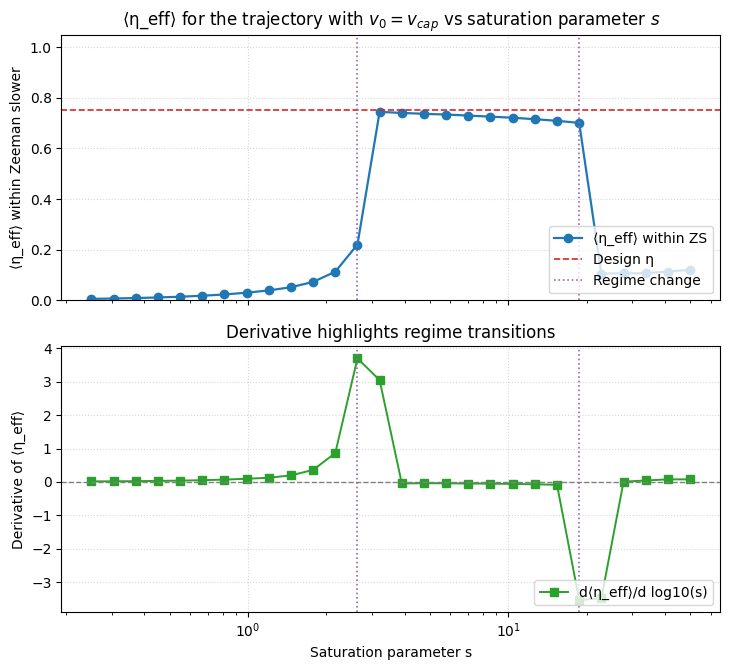

HTML(value="<div style='margin-top:0.3em'><b>Regime-change candidates</b>: s≈2.63 | s≈18.74</div>")

In [5]:
# Average η_eff along the Zeeman slower vs saturation parameter
advanced_state = globals().get("_advanced_state")
if not advanced_state:
    raise RuntimeError("Run the advanced Zeeman slower widget before executing this analysis.")
if "plot_phase_space" not in globals():
    raise RuntimeError("Run the phase-space cell once so helper functions are defined and cached.")
# Retrieve stored profile and parameters.
species_props = dict(advanced_state["species_props"])
gamma = float(species_props["gamma"])
wavelength = float(species_props["wavelength"])
mass = float(species_props["mass"]) * amu
sat_in = species_props.get("sat_intensity", 60.0) or 60.0
params = advanced_state["params"]
g_eff_val = float(params["g_eff"])
v_capture = float(params["v0"])
v_final = float(params["vf"])
if v_capture <= v_final:
    raise RuntimeError("Stored profile has v0 <= vf. Re-run ZS Magnetic field design with valid parameters.")
z_axis_core = np.asarray(advanced_state["z"])
z_profile = np.asarray(advanced_state["z_extended"])
B_profile_extended = np.asarray(advanced_state["B_extended"])
if z_profile.size == 0 or B_profile_extended.size == 0:
    raise RuntimeError("Extended magnetic profile is empty. Re-run ZS Magnetic field design with valid parameters.")
kk = 2 * math.pi / wavelength
diag = advanced_state["diagnostics"]
delta_design = float(diag["delta_ideal"])
eta_design = float(params["eta"])
z_slower_start, z_slower_end = advanced_state["slower_bounds"]
z_min, z_max = float(z_profile[0]), float(z_profile[-1])
L_design = float(advanced_state["L"])
flight_time = max(L_design / max(v_capture, 1.0), 1e-5)
base_dt = flight_time / max(len(z_axis_core) - 1, 1)
base_steps = max(len(z_profile), 2)
min_speed = 1e-4  # m/s to avoid stalling


def scattering_force_and_eta(delta_laser, B_T, velocities, s_value):
    delta = delta_laser + kk * velocities + g_eff_val * mu_B * B_T / hbar
    denom = 1.0 + s_value + (2.0 * delta / gamma) ** 2
    force = hbar * kk * gamma / 2.0 * (s_value / denom)
    return force, s_value / denom


def integrate_trajectory(v_init, delta_laser, s_value, record_eta=False):
    '''Integrate a single trajectory starting from z_min with initial velocity v_init'''
    # Adjust max steps based on initial speed to ensure adequate resolution
    speed_scale = max(1.0, v_capture / max(abs(v_init), min_speed))
    max_steps = int(math.ceil(base_steps * speed_scale * 8.0))
    # Initialize trajectory lists
    traj_z = [z_min]
    traj_v = [v_init]
    eta_samples = [] if record_eta else None
    # Time-stepping loop
    for _ in range(max_steps):
        # Get current position and velocity
        v_curr = traj_v[-1]
        z_curr = traj_z[-1]
        # Prevent stalling at very low speeds
        if abs(v_curr) < min_speed:
            prev = traj_v[-2] if len(traj_v) > 1 else 1.0
            v_curr = np.copysign(min_speed, prev)
            traj_v[-1] = v_curr
        # Sample magnetic field and compute force
        z_sample = float(np.clip(z_curr, z_min, z_max))
        B_val = np.interp(z_sample, z_profile, B_profile_extended)
        force, eta_point = scattering_force_and_eta(delta_laser, B_val, v_curr, s_value)
        # Update velocity and position using Euler integration
        accel = -force / mass
        v_next = v_curr + accel * base_dt
        z_next = z_curr + v_curr * base_dt
        traj_v.append(v_next)
        traj_z.append(z_next)
        if record_eta:
            eta_samples.append(eta_point)

        # Termination conditions: exit if outside z bounds and moving away
        if (z_next <= z_min and v_next <= 0) or (z_next >= z_max and v_next >= 0):
            break
    if record_eta:
        return np.asarray(traj_z), np.asarray(traj_v), np.asarray(eta_samples)
    return np.asarray(traj_z), np.asarray(traj_v)

def _eta_sweep_integrate_capture(s_value, delta_laser):
    speed_scale = max(1.0, v_capture / max(abs(v_capture), min_speed))
    max_steps = int(math.ceil(base_steps * speed_scale * 8.0))
    traj_z = [z_min]
    traj_v = [v_capture]
    eta_samples = []
    for _ in range(max_steps):
        v_curr = traj_v[-1]
        z_curr = traj_z[-1]
        if abs(v_curr) < min_speed:
            prev = traj_v[-2] if len(traj_v) > 1 else v_capture
            v_curr = np.copysign(min_speed, prev)
            traj_v[-1] = v_curr
        z_sample = float(np.clip(z_curr, z_min, z_max))
        B_val = np.interp(z_sample, z_profile, B_profile_extended)
        force, eta_point = scattering_force_and_eta(delta_laser, B_val, v_curr, s_value)
        # 
        accel = -force / mass
        v_next = v_curr + accel * base_dt
        z_next = z_curr + v_curr * base_dt
        traj_v.append(v_next)
        traj_z.append(z_next)
        eta_samples.append(eta_point)
        if (z_next <= z_min and v_next <= 0) or (z_next >= z_max and v_next >= 0):
            break
    eta_samples = np.asarray(eta_samples)
    z_eta = np.asarray(traj_z[1 : eta_samples.size + 1])
    return z_eta, eta_samples

# Use a denser sampling of saturation parameters to reveal regime changes.
sweep_s_values = np.geomspace(0.25, 50.0, 28)
eta_means = []
for s_value in sweep_s_values:
    z_eta, eta_samples = _eta_sweep_integrate_capture(s_value, delta_design)
    if eta_samples.size == 0:
        eta_means.append(np.nan)
        continue
    # Compute mean eta_eff within the Zeeman slower region.
    mask = (z_eta >= z_slower_start) & (z_eta <= z_slower_end)  # Only samples within ZS
    eta_means.append(float(np.mean(eta_samples[mask])) if np.any(mask) else np.nan)
eta_means = np.asarray(eta_means)

log_s = np.log10(sweep_s_values)  # Logarithm of saturation parameters

# Numerical derivative of ⟨η_eff⟩ with respect to log10(s)
eta_derivative = np.full_like(eta_means, np.nan, dtype=float)  # Initialize with NaNs
finite_mask = np.isfinite(eta_means)  # Only compute derivative where eta_means is finite
if np.count_nonzero(finite_mask) >= 3:
    # Compute numerical derivative using finite differences
    eta_derivative[finite_mask] = np.gradient(
        eta_means[finite_mask],
        log_s[finite_mask],
    )

# Identify up to two saturation parameter values where the derivative magnitude is largest
transition_indices = []
finite_deriv_idx = np.where(np.isfinite(eta_derivative))[0]
# Rank by absolute derivative value
if finite_deriv_idx.size >= 2:  # Need at least two finite points to find transitions
    # Get indices sorted by descending absolute derivative
    ranked = finite_deriv_idx[np.argsort(np.abs(eta_derivative[finite_deriv_idx]))[::-1]]
    for idx in ranked:
        if idx not in transition_indices:
            transition_indices.append(idx)
        if len(transition_indices) == 2:
            break
transition_s = [sweep_s_values[i] for i in transition_indices]  # Corresponding s values

fig, (ax_eta, ax_deriv) = plt.subplots(2, 1, figsize=(7.4, 6.8), sharex=True)

ax_eta.plot(sweep_s_values, eta_means, marker="o", lw=1.6, label="⟨η_eff⟩ within ZS")
ax_eta.axhline(eta_design, color="tab:red", ls="--", lw=1.2, label="Design η")
for idx in transition_indices:
    s_val = sweep_s_values[idx]
    ax_eta.axvline(
        s_val,
        color="tab:purple",
        ls=":",
        lw=1.2,
        label="Regime change" if idx == transition_indices[0] else None,
    )
ax_eta.set_xscale("log")
ax_eta.set_ylabel("⟨η_eff⟩ within Zeeman slower")
ax_eta.set_ylim(0.0, 1.05)
ax_eta.grid(True, ls=":", alpha=0.5)
ax_eta.legend(loc="lower right")
ax_eta.set_title("⟨η_eff⟩ for the trajectory with $v_0 = v_{cap}$ vs saturation parameter $s$")

ax_deriv.plot(
    sweep_s_values,
    eta_derivative,
    color="tab:green",
    marker="s",
    lw=1.4,
    label="d⟨η_eff⟩/d log10(s)",
)
for idx in transition_indices:
    s_val = sweep_s_values[idx]
    ax_deriv.axvline(
        s_val,
        color="tab:purple",
        ls=":",
        lw=1.2,
    )
ax_deriv.axhline(0.0, color="gray", ls="--", lw=1.0)
ax_deriv.set_xscale("log")
ax_deriv.set_xlabel("Saturation parameter s")
ax_deriv.set_ylabel("Derivative of ⟨η_eff⟩")
ax_deriv.grid(True, ls=":", alpha=0.5)
ax_deriv.legend(loc="lower right")
ax_deriv.set_title("Derivative highlights regime transitions")
plt.tight_layout()
plt.show()
# # Summary table of results
# table_rows = [
#     (
#         f"s = {s_val:>6.2f} → ⟨η_eff⟩ = {eta_val:.3f}, "
#         f"d⟨η_eff⟩/dlog10(s) = {eta_derivative[i]:+.3f}"
#     )
#     if math.isfinite(eta_val) and math.isfinite(eta_derivative[i])
#     else (
#         f"s = {s_val:>6.2f} → ⟨η_eff⟩ = "
#         + (f"{eta_val:.3f}" if math.isfinite(eta_val) else "n/a")
#         + ", d⟨η_eff⟩/dlog10(s) = n/a"
#     )
#     for i, (s_val, eta_val) in enumerate(zip(sweep_s_values, eta_means))
# ]

if transition_s:
    transition_text = " | ".join([f"s≈{val:.2f}" for val in transition_s])
    transition_html = f"<b>Regime-change candidates</b>: {transition_text}"
else:
    transition_html = "<b>Regime-change candidates</b>: n/a"

# display(
#     w.HTML(
#         "<pre style='font-size:0.95em; margin-top:0.4em'>"
#         + "\n".join(table_rows)
#         + "</pre>"
#     )
# )
display(w.HTML(f"<div style='margin-top:0.3em'>{transition_html}</div>"))

In [6]:
from scipy.optimize import least_squares


# Angles for the 8 segments of the Halbach array
BETAS = np.linspace(0, 2 * np.pi, 8, endpoint=False)  # n * pi/4 for n=0..7
EPS = 1e-12  # Small value to prevent division by zero


def _broadcast(*arrays):
    """Broadcast input arrays to a common shape with float dtype."""
    return np.broadcast_arrays(*[np.asarray(arr, dtype=float) for arr in arrays])


def translate_to_ring_frame(x, y, z, r0, z0, beta):
    """Translate lab-frame coordinates to the displaced magnet frame."""
    x, y, z, r0, z0 = _broadcast(x, y, z, r0, z0)
    xp = x - r0 * np.sin(beta)
    yp = y - r0 * np.cos(beta)
    zp = z - z0
    return xp, yp, zp


def rotate_xy_plane(x, y, angle):
    """Rotate coordinates in the XY plane by the provided angle."""
    x, y, angle = _broadcast(x, y, angle)
    c = np.cos(angle)
    s = np.sin(angle)
    xr = c * x - s * y
    yr = s * x + c * y
    return xr, yr


def rotate_about_v(xs, ys, zs, alpha, beta):
    """Rotate coordinates about the Halbach axis defined by beta."""
    xs, ys, zs, alpha = _broadcast(xs, ys, zs, alpha)
    cb = np.cos(beta)
    sb = np.sin(beta)
    ca = np.cos(alpha)
    sa = np.sin(alpha)
    xt = (cb**2 * (1 - ca) + ca) * xs + cb * sb * (1 - ca) * ys + sb * sa * zs
    yt = cb * sb * (1 - ca) * xs + (sb**2 * (1 - ca) + ca) * ys - cb * sa * zs
    zt = -sb * sa * xs + cb * sa * ys + ca * zs
    return xt, yt, zt


def inverse_rotate_about_v(bxt, byt, bzt, alpha, beta):
    """Undo the rotation about the Halbach axis for vector components."""
    bxt, byt, bzt, alpha = _broadcast(bxt, byt, bzt, alpha)
    cb = np.cos(beta)
    sb = np.sin(beta)
    ca = np.cos(alpha)
    sa = np.sin(alpha)
    bxs = (cb**2 * (1 - ca) + ca) * bxt + cb * sb * (1 - ca) * byt - sb * sa * bzt
    bys = cb * sb * (1 - ca) * bxt + (sb**2 * (1 - ca) + ca) * byt + cb * sa * bzt
    bzs = sb * sa * bxt - cb * sa * byt + ca * bzt
    return bxs, bys, bzs


def brond(x, y, z):
    """Calculate the magnetic field components from a rectangular magnet at position (x, y, z)."""
    x, y, z = _broadcast(x, y, z)   # Ensure inputs are numpy arrays with float dtype
    r = np.sqrt(x**2 + y**2 + z**2) + EPS  # Norm with EPS to avoid division by zero
    # Compute field components
    bxx = 0.5 * np.log(np.clip(r - z, EPS, None) / np.clip(r + z, EPS, None))
    byy = -np.arctan(np.divide(y * r, x * z + EPS))
    bzz = 0.5 * np.log(np.clip(r - x, EPS, None) / np.clip(r + x, EPS, None))
    return np.stack((bxx, byy, bzz), axis=-1)


def bmagnet(x, y, z, a, b, c, Br):
    """Calculate the magnetic field from a rectangular magnet
    with dimensions (2a, 2b, 2c) and remanent field Br at position (x, y, z)."""
    term = (
        brond(x - a, y - b, z - c) - brond(x + a, y - b, z - c)
        + brond(x + a, y + b, z - c) - brond(x - a, y + b, z - c)
        + brond(x - a, y + b, z + c) - brond(x - a, y - b, z + c)
        + brond(x + a, y - b, z + c) - brond(x + a, y + b, z + c)
    )
    return (Br / (4 * np.pi)) * term


def bdisrot(x, y, z, a, b, c, Br, r0, z0, alpha, beta):
    """Calculate the magnetic field from a rotated and displaced rectangular magnet."""
    x, y, z, r0, z0, alpha = _broadcast(x, y, z, r0, z0, alpha)
    xp, yp, zp = translate_to_ring_frame(x, y, z, r0, z0, beta)
    xs, ys = rotate_xy_plane(xp, yp, 2 * beta)
    xt, yt, zt = rotate_about_v(xs, ys, zp, alpha, beta)
    bvec = bmagnet(xt, yt, zt, a, b, c, Br)
    bxt = bvec[..., 0]
    byt = bvec[..., 1]
    bzt = bvec[..., 2]
    bxs, bys, bzs = inverse_rotate_about_v(bxt, byt, bzt, alpha, beta)
    bx, by = rotate_xy_plane(bxs, bys, -2 * beta)
    return np.stack((bx, by, bzs), axis=-1)


def bhallbach8(x, y, z, a, b, c, Br, R0, z0, alpha):
    """Calculate the magnetic field from an 8-segment Halbach array."""
    total = None
    for beta in BETAS:
        btmp = bdisrot(x, y, z, a, b, c, Br, R0, z0, alpha, beta)
        if total is None:
            total = np.zeros_like(btmp)
        total += btmp
    return total


def by_component(x, y, z, a, b, c, Br, R0, z0, alpha):
    '''Calculate the By component of the magnetic field from an 8-segment Halbach array.'''
    return bhallbach8(x, y, z, a, b, c, Br, R0, z0, alpha)[..., 1]

HTML(value="<b>Halbach geometry controls</b>: switch to 'Custom overrides' to edit magnet geometry/field assum…

Best-fit: c = 131.8 mm, R0 = 26.0 mm, z0 = 134.5 mm, alpha = -4.30°
Inside slower: 257.1 mm | Outside entrance: 0.0 mm | Outside exit: 6.6 mm
Magnet span: z = 2.7 to 266.3 mm (center 134.5 mm)
Zero-field regions (extended profile): [-196.3, -0.4] mm (195.9 mm), [260.1, 312.7] mm (52.6 mm)
Halbach vs ideal RMS error: 28.49 G
Cached Halbach axis fit under globals()['halbach_axis_fit'] for downstream use.


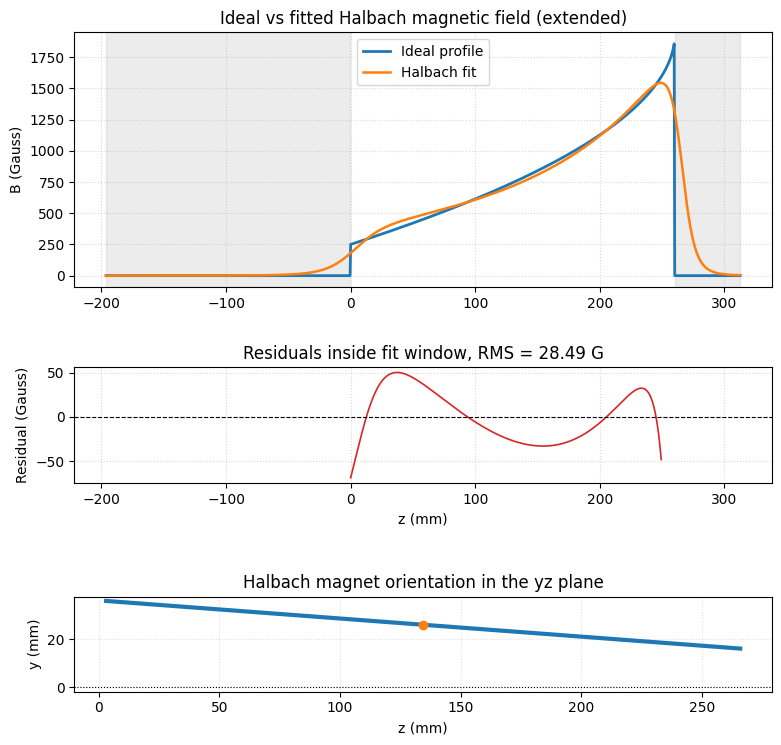

In [7]:
# Default Halbach geometry parameters in millimeters and Gauss
HALBACH_DEFAULTS = {
    "a_mm": 6.0 / 2.0,
    "b_mm": 6.0 / 2.0,
    "c_mm": 128.0 / 2.0,
    "Br": 1.08e4,  # Remanent field in Gauss
    "R0_mm": 54.0 / 2.0,
    "z0_mm": 0.0,
    "alpha_deg": -0.97,
}

# Preserve reference values so the UI can snap back to the shipped defaults on demand.
HALBACH_BASE_DEFAULTS = dict(HALBACH_DEFAULTS)
HALBACH_PARAM_UNITS = {
    "a_mm": "mm",
    "b_mm": "mm",
    "c_mm": "mm",
    "Br": "Gauss",
    "R0_mm": "mm",
    "z0_mm": "mm",
    "alpha_deg": "deg",
}


def _build_halbach_controls():
    """Return the shared toggle + numeric inputs for Halbach parameters."""
    inputs = {}
    rows = []
    for key, default in HALBACH_DEFAULTS.items():
        field = w.FloatText(
            value=default,
            description=f"{key} ({HALBACH_PARAM_UNITS[key]})",
            disabled=True,
            layout=w.Layout(width="260px"),
        )

        def _make_value_handler(target_key):
            def _handler(change):
                if halbach_mode_toggle.value == "custom":
                    HALBACH_DEFAULTS[target_key] = float(change["new"])
            return _handler

        field.observe(_make_value_handler(key), names="value")
        inputs[key] = field
        rows.append(field)

    mode_toggle = w.ToggleButtons(
        options=[("Use defaults", "default"), ("Custom overrides", "custom")],
        value="default",
        description="Halbach params",
        layout=w.Layout(width="320px"),
    )

    def _mode_handler(change):
        use_custom = change["new"] == "custom"
        for key, widget in inputs.items():
            widget.disabled = not use_custom
            if not use_custom:
                HALBACH_DEFAULTS[key] = HALBACH_BASE_DEFAULTS[key]
                widget.value = HALBACH_BASE_DEFAULTS[key]

    mode_toggle.observe(_mode_handler, names="value")

    globals()["halbach_mode_toggle"] = mode_toggle
    globals()["_halbach_param_inputs"] = inputs
    return w.VBox([mode_toggle, w.VBox(rows, layout=w.Layout(gap="4px"))])


_halbach_param_box = _build_halbach_controls()

display(
    w.HTML(
        "<b>Halbach geometry controls</b>: switch to 'Custom overrides' to edit magnet geometry/field assumptions used in the fits."
    ),
    _halbach_param_box,
)

# Helper functions for Halbach field calculations and fitting
def _defaults_mks():
    """Return Halbach geometry defaults converted to SI units."""
    return {
        "a": HALBACH_DEFAULTS["a_mm"] * 1e-3,
        "b": HALBACH_DEFAULTS["b_mm"] * 1e-3,
        "c": HALBACH_DEFAULTS["c_mm"] * 1e-3,
        "R0": HALBACH_DEFAULTS["R0_mm"] * 1e-3,
        "z0": HALBACH_DEFAULTS["z0_mm"] * 1e-3,
    }


# Compute Halbach field along the z-axis
def halbach_axis_field(z_m, c_m, R0_m, z0_m, alpha_deg, *, a_m=None, b_m=None, Br=None):
    """Return the By component (Tesla) of the Halbach stack along the z-axis."""
    cfg = _defaults_mks()  # Get default geometry in meters
    # Use provided or default values
    a_m = cfg["a"] if a_m is None else a_m
    b_m = cfg["b"] if b_m is None else b_m
    Br = HALBACH_DEFAULTS["Br"] if Br is None else Br
    alpha_rad = np.deg2rad(alpha_deg)
    # Compute By field in Gauss
    by_gauss = by_component(
        0.0,
        0.0,
        z_m,
        a_m,
        b_m,
        c_m,
        Br,
        R0_m,
        z0_m,
        alpha_rad,
    )
    return by_gauss * 1e-4  # Convert Gauss → Tesla


# Load the ideal Zeeman slower profile from the cached advanced state
def _load_ideal_profile(*, include_extended=True):
    state = globals().get("_advanced_state")
    if not state:
        raise RuntimeError(
            "Run the advanced Zeeman slower design cell first so the ideal magnetic profile is cached."
        )
    z_key = "z_extended" if include_extended and "z_extended" in state else "z"
    B_key = "B_extended" if include_extended and "B_extended" in state else "B"
    z_profile = np.asarray(state[z_key], dtype=float)
    B_profile = np.asarray(state[B_key], dtype=float)
    if z_profile.size == 0 or B_profile.size == 0:
        raise RuntimeError("Cached ideal profile is empty; rerun the design cell with valid parameters.")
    return z_profile, B_profile, state


# Extract contiguous segments from a boolean mask
def _segments_from_mask(z_vals, mask):
    """Return start/end index pairs for contiguous True regions in mask."""
    segments = []
    if not np.any(mask):
        return segments
    start_idx = None
    for idx, flag in enumerate(mask):
        if flag and start_idx is None:
            start_idx = idx
        elif not flag and start_idx is not None:
            segments.append((start_idx, idx - 1))
            start_idx = None
    if start_idx is not None:
        segments.append((start_idx, np.where(mask)[0][-1]))
    return [(z_vals[i0], z_vals[i1]) for i0, i1 in segments]


def fit_halbach_to_ideal(fit_window_m=None, include_extended=True, zero_tol_T=1e-8):
    """Fit the Halbach By field to the stored ideal Zeeman-slower profile."""
    z_profile, B_profile, state = _load_ideal_profile(include_extended=include_extended)
    if fit_window_m is None:
        mask = np.ones_like(z_profile, dtype=bool)
    else:
        z_min, z_max = fit_window_m
        mask = (z_profile >= z_min) & (z_profile <= z_max)
    z_fit = z_profile[mask]     # Fit region
    B_target = B_profile[mask]  # Target field in fit region
    if z_fit.size < 4:
        raise RuntimeError("Fit window is too small; ensure the mask keeps at least 4 samples.")

    # Initial guess and bounds for [c, R0, z0, alpha_deg]
    geom = _defaults_mks()
    par0 = np.array([
        geom["c"],
        geom["R0"],
        geom["z0"],
        HALBACH_DEFAULTS["alpha_deg"],
    ])
    # Bounds for parameters
    lower_bounds = np.array([2e-3, 5e-3, -0.15, -15.0])
    upper_bounds = np.array([0.25, 0.06, 0.40, 15.0])

    def residuals(p):
        c_m, R0_m, z0_m, alpha_deg = p
        halbach_T = halbach_axis_field(
            z_fit,
            c_m,
            R0_m,
            z0_m,
            alpha_deg,
            a_m=geom["a"],
            b_m=geom["b"],
            Br=HALBACH_DEFAULTS["Br"],
        )
        return halbach_T - B_target

    result = least_squares(residuals, par0, bounds=(lower_bounds, upper_bounds))
    fitted_profile_T = halbach_axis_field(
        z_fit,
        result.x[0],
        result.x[1],
        result.x[2],
        result.x[3],
        a_m=geom["a"],
        b_m=geom["b"],
        Br=HALBACH_DEFAULTS["Br"],
    )
    error_T = fitted_profile_T - B_target
    # Compute RMS error in Gauss
    # RMS is Root Mean Square of the residuals
    rms_error_G = np.sqrt(np.mean(error_T**2)) * 1e4

    halbach_full_T = halbach_axis_field(
        z_profile,
        result.x[0],
        result.x[1],
        result.x[2],
        result.x[3],
        a_m=geom["a"],
        b_m=geom["b"],
        Br=HALBACH_DEFAULTS["Br"],
    )
    # Identify zero-field segments in the ideal profile (for shading area plot)
    zero_mask = np.isclose(B_profile, 0.0, atol=zero_tol_T)
    zero_segments = _segments_from_mask(z_profile, zero_mask)

    fig = plt.figure(figsize=(9, 9))
    # Create a gridspec layout for the three subplots
    gs = fig.add_gridspec(3, 1, height_ratios=[2.2, 1.0, 1.4], hspace=0.45)
    ax_main = fig.add_subplot(gs[0])
    ax_err = fig.add_subplot(gs[1], sharex=ax_main)
    ax_orient = fig.add_subplot(gs[2])

    # Main plot: Ideal vs fitted Halbach profile
    for start_m, end_m in zero_segments:
        ax_main.axvspan(start_m * 1e3, end_m * 1e3, color="gray", alpha=0.15)
    ax_main.plot(z_profile * 1e3, B_profile * 1e4, label="Ideal profile", lw=2.0)
    ax_main.plot(z_profile * 1e3, halbach_full_T * 1e4, label="Halbach fit", lw=1.8)
    ax_main.set_ylabel("B (Gauss)")
    ax_main.set_title("Ideal vs fitted Halbach magnetic field (extended)")
    ax_main.grid(True, ls=":", alpha=0.5)
    ax_main.legend()

    # Residuals plot: Fit window errors
    ax_err.plot(z_fit * 1e3, error_T * 1e4, color="tab:red", lw=1.2)
    ax_err.axhline(0.0, color="k", lw=0.8, ls="--")
    ax_err.set_xlabel("z (mm)")
    ax_err.set_ylabel("Residual (Gauss)")
    ax_err.grid(True, ls=":", alpha=0.5)
    ax_err.set_title(f"Residuals inside fit window, RMS = {rms_error_G:.2f} G")

    # Orientation plot: Halbach axis in yz plane
    c_m, R0_m, z0_m, alpha_deg = result.x
    alpha_rad = np.deg2rad(alpha_deg)
    span = np.array([-c_m, c_m])
    z_line = (z0_m + span * np.cos(alpha_rad)) * 1e3
    y_line = (R0_m + span * np.sin(alpha_rad)) * 1e3
    ax_orient.plot(z_line, y_line, color="tab:blue", lw=3)
    ax_orient.scatter([z0_m * 1e3], [R0_m * 1e3], color="tab:orange", zorder=3)
    ax_orient.axhline(0.0, color="k", lw=0.8, ls=":")
    ax_orient.set_xlabel("z (mm)")
    ax_orient.set_ylabel("y (mm)")
    ax_orient.set_title("Halbach magnet orientation in the yz plane")
    ax_orient.set_aspect("equal", adjustable="box")
    ax_orient.grid(True, ls=":", alpha=0.4)

    # Summary of fitted parameters and lengths
    fitted_mm = {
        "c_mm": c_m * 1e3,
        "R0_mm": R0_m * 1e3,
        "z0_mm": z0_m * 1e3,
        "alpha_deg": alpha_deg,
    }
    summary = (
        f"Best-fit: c = {fitted_mm['c_mm']:.1f} mm, R0 = {fitted_mm['R0_mm']:.1f} mm, "
        f"z0 = {fitted_mm['z0_mm']:.1f} mm, alpha = {fitted_mm['alpha_deg']:.2f}°"
    )

    # Compute lengths inside/outside the slower region
    slower_min, slower_max = state["slower_bounds"]
    mag_min = z0_m - c_m
    mag_max = z0_m + c_m
    overlap = max(0.0, min(mag_max, slower_max) - max(mag_min, slower_min))
    outside_before = max(0.0, slower_min - mag_min)
    outside_after = max(0.0, mag_max - slower_max)
    total_length_mm = 2 * c_m * 1e3
    overlap_mm = overlap * 1e3
    outside_before_mm = outside_before * 1e3
    outside_after_mm = outside_after * 1e3
    magnet_span_mm = (mag_min * 1e3, mag_max * 1e3)
    zero_segments_mm = [
        (start * 1e3, end * 1e3, (end - start) * 1e3)
        for start, end in zero_segments
    ]

    print(summary)
    print(
        f"Inside slower: {overlap_mm:.1f} mm | Outside entrance: {outside_before_mm:.1f} mm | "
        f"Outside exit: {outside_after_mm:.1f} mm"
    )
    print(
        f"Magnet span: z = {magnet_span_mm[0]:.1f} to {magnet_span_mm[1]:.1f} mm (center {fitted_mm['z0_mm']:.1f} mm)"
    )
    if zero_segments_mm:
        zero_text = ", ".join(
            f"[{start:.1f}, {end:.1f}] mm ({length:.1f} mm)"
            for start, end, length in zero_segments_mm
        )
    else:
        zero_text = "None"
    print(f"Zero-field regions (extended profile): {zero_text}")
    print(f"Halbach vs ideal RMS error: {rms_error_G:.2f} G")
    return {
        "result": result,
        "z_fit": z_fit,
        "ideal_profile_T": B_target,
        "ideal_profile_full_T": B_profile,
        "halbach_profile_T": fitted_profile_T,
        "halbach_full_T": halbach_full_T,
        "z_profile": z_profile,
        "residuals_T": error_T,
        "summary": summary,
        "rms_error_G": rms_error_G,
        "lengths_mm": {
            "total": total_length_mm,
            "inside": overlap_mm,
            "outside_before": outside_before_mm,
            "outside_after": outside_after_mm,
        },
        "magnet_span_mm": magnet_span_mm,
        "zero_segments_mm": zero_segments_mm,
    }


halbach_axis_fit = fit_halbach_to_ideal(fit_window_m=[0, advanced_state["L"] - 0.01], include_extended=True)
globals()["halbach_axis_fit"] = halbach_axis_fit
print("Cached Halbach axis fit under globals()['halbach_axis_fit'] for downstream use.")

In [8]:
# PARAMS AND GUI SETUP

advanced_state = globals().get("_advanced_state")
if not advanced_state:
    raise RuntimeError(
        "Run previous cell (advanced Zeeman slower widget) before executing this cell so the magnetic profile is available."
    )

# Retrieve stored profile and parameters.
species_name = advanced_state["species"]
species_props = advanced_state["species_props"]
spec = dict(species_props)

# Pull the stored species values so this cell mirrors the widget configuration.
wavelength = spec["wavelength"]
gamma = spec["gamma"]
mass = spec["mass"] * amu
sat_in = spec["sat_intensity"] if "sat_intensity" in spec else 60.0
kk = 2 * math.pi / wavelength

# Extract parameters from stored state.
params = advanced_state["params"]
g_eff_val = float(params["g_eff"])
v_capture = float(params["v0"])
v_final = float(params["vf"])
if v_capture <= v_final:
    raise RuntimeError(
        "Stored profile has v0 <= vf. Rerun cell (adv ZS widget) with valid parameters."
    )
z_axis_core = np.asarray(advanced_state["z"])
B_profile_core = np.asarray(advanced_state["B"])
z_profile = np.asarray(advanced_state["z_extended"])
B_profile_extended = np.asarray(advanced_state["B_extended"])
L_design = float(advanced_state["L"])
slower_bounds = advanced_state["slower_bounds"]
z_slower_start, z_slower_end = slower_bounds
diag = advanced_state["diagnostics"]
delta_design = float(diag["delta_ideal"])
eta_design = float(params["eta"])
F_max = float(diag["F_max"])
a_max = float(diag["a_max"])
ideal_detuning = float(diag["delta_ideal"])

# Pull the latest fitted Halbach field so the trajectories use the realized magnets.
sectioned_source = (
    globals().get("sectioned_widget_fit")
    or globals().get("sectioned_fixed_fit")
    or globals().get("halbach_axis_fit")
)
if not sectioned_source:
    raise RuntimeError(
        "Run the Halbach fit cell (or sectioned fit) before executing this cell so the fitted magnetic field is cached."
    )
fitted_z_axis = np.asarray(sectioned_source["z_profile"], dtype=float)
fitted_field_profile = np.asarray(sectioned_source["halbach_full_T"], dtype=float)
if fitted_z_axis.shape != fitted_field_profile.shape:
    raise RuntimeError(
        "Fitted field data is inconsistent; rerun the Halbach fit so the field can be interpolated."
    )

# Use the fitted Halbach field for all subsequent force calculations.
z_profile = fitted_z_axis
B_profile_extended = fitted_field_profile

# Slider controls to explore different scattering intensities and laser detunings around the ideal design.
intensity_slider = w.FloatSlider(
    description="I (mW/cm²)",
    value=600.0,
    min=10.0,
    max=2000.0,
    step=10.0,
    continuous_update=False,
)
span_ghz = max(0.5, abs(ideal_detuning / (2 * math.pi * 1e9)) * 0.5)

# Detuning slider (Δ/2π in GHz) centered on the design detuning, with an explanatory tooltip.
detuning_center_ghz = ideal_detuning / (2 * math.pi * 1e9)
detuning_slider = w.FloatSlider(
    description="Δ/2π (GHz)",
    value=detuning_center_ghz,
    min=detuning_center_ghz - span_ghz / 2.0,
    max=detuning_center_ghz + span_ghz / 2.0,
    step=0.005,
    continuous_update=False,
    readout_format=".3f",
)
detuning_slider.tooltip = (
    "Laser detuning from the atomic resonance divided by 2π, expressed in GHz. "
    "Negative values are red-detuned. Range is centered on the design detuning."
)
traj_count_slider = w.IntSlider(
    description="Traj count",
    value=12,
    min=4,
    max=40,
    step=1,
    continuous_update=False,
)
max_v0_slider = w.FloatSlider(
    description="Max v0 (m/s)",
    value=v_capture * 1.2,
    min=max(1.0, v_final * 0.9),
    max=v_capture * 1.7,
    step=10.0,
    continuous_update=False,
)

# Info labels
ideal_detuning_label = w.HTML(
    f"<b>Ideal detuning/2&pi;</b>: {detuning_center_ghz:.3f} GHz"
)
sat_info_label = w.HTML(
    f"<b>Saturation intensity</b>: {sat_in:.1f} mW/cm²<br><b>s</b>: {600.0 / sat_in:.2f} (I/I_sat)"
)
eta_reference_label = w.HTML("<b>Capture trajectory ⟨&eta;<sub>eff</sub>&rang;</b>: n/a")

# -------------------- FORCE MAP and TRAJECTORIES SIMULATION --------------------
# Sample velocities well below zero so the force map shows deceleration all the way through the stop.
v_min = -0.25 * v_capture
v_max = max_v0_slider.value * 1.05
vel_axis = np.linspace(v_min, v_max, 500)
gray_cmap = ListedColormap(plt.cm.Greys(np.linspace(0.0, 0.85, 256)))

# Precompute quantities for trajectory integration.
z_min, z_max = float(z_profile[0]), float(z_profile[-1])
flight_time = L_design / v_capture

# flight time for the design velocity profile through the slower as an integration of v(z)=dz/dt:
def _inv_velocity(z_rel: float) -> float:
    v_sq = v_capture**2 - (v_capture**2 - v_final**2) * z_rel / L_design
    return 1.0 / math.sqrt(max(v_sq, 1e-12))

flight_time_ideal, _ = integrate.quad(_inv_velocity, 0.0, L_design, limit=200)

# Sanity check on flight time.
if flight_time < 1e-6:
    raise RuntimeError("Unrealistically short flight time through the slower; check v0 and slower length.")
print("Estimated flight time through the slower ct capture vel {:.3f} ms".format(flight_time * 1e3))
print("Estimated flight time (cap vel ideal profile) {:.3f} ms".format(flight_time_ideal * 1e3))
base_dt = flight_time / max(len(z_axis_core) - 1, 1)
base_steps = max(len(z_profile), 2)
min_speed = 1e-4  # m/s to avoid stalling

# Interpolate the fitted magnetic field profile onto a finer z grid for force map rendering.
z_force = np.linspace(z_min, z_max, max(len(z_profile), 800))
B_force = np.interp(z_force, z_profile, B_profile_extended)

# Identify field-free drift regions before and after the slower for plotting visualization.
drift_regions = []
if z_min < z_slower_start:
    drift_regions.append((z_min, z_slower_start))
if z_max > z_slower_end:
    drift_regions.append((z_slower_end, z_max))


def scattering_force_and_eta(delta_laser, B_T, velocities, s_value):
    delta = delta_laser + kk * velocities + g_eff_val * mu_B * B_T / hbar
    denom = 1.0 + s_value + (2.0 * delta / gamma) ** 2
    force = hbar * kk * gamma / 2.0 * (s_value / denom)
    return force, s_value / denom


def integrate_trajectory(v_init, delta_laser, s_value, record_eta=False):
    """Integrate a single trajectory starting from z_min with initial velocity v_init"""
    # Adjust max steps based on initial speed to ensure adequate resolution
    speed_scale = max(1.0, v_capture / max(abs(v_init), min_speed))
    max_steps = int(math.ceil(base_steps * speed_scale * 8.0))
    # Initialize trajectory lists
    traj_z = [z_min]
    traj_v = [v_init]
    eta_samples = [] if record_eta else None
    # Time-stepping loop
    for _ in range(max_steps):
        # Get current position and velocity
        v_curr = traj_v[-1]
        z_curr = traj_z[-1]
        # Prevent stalling at very low speeds
        if abs(v_curr) < min_speed:
            prev = traj_v[-2] if len(traj_v) > 1 else 1.0
            v_curr = np.copysign(min_speed, prev)
            traj_v[-1] = v_curr
        # Sample magnetic field and compute force
        z_sample = float(np.clip(z_curr, z_min, z_max))
        B_val = np.interp(z_sample, z_profile, B_profile_extended)
        force, eta_point = scattering_force_and_eta(delta_laser, B_val, v_curr, s_value)
        # Update velocity and position using Euler integration
        accel = -force / mass
        v_next = v_curr + accel * base_dt
        z_next = z_curr + v_curr * base_dt
        traj_v.append(v_next)
        traj_z.append(z_next)
        if record_eta:
            eta_samples.append(eta_point)

        # Termination conditions: exit if outside z bounds and moving away
        if (z_next <= z_min and v_next <= 0) or (z_next >= z_max and v_next >= 0):
            break
    if record_eta:
        return np.asarray(traj_z), np.asarray(traj_v), np.asarray(eta_samples)
    return np.asarray(traj_z), np.asarray(traj_v)


def plot_phase_space(intensity_mw_cm2, detuning_ghz, trajectory_count, max_initial_velocity):
    s0_val = intensity_mw_cm2 / sat_in if sat_in else 0.0  # Saturation parameter
    delta_laser = detuning_ghz * 1e9 * 2.0 * math.pi       # Convert GHz to rad/s
    # Compute and update saturation info label.
    eta_ideal_slider = params["eta"]  # Ideal eta from the stored profile
    sat_info_label.value = (
        f"<b>Saturation intensity</b>: {sat_in:.1f} mW/cm²"
        f"<br><b>s</b> = {s0_val:.3f} (I/I_sat)"
        f"<br><b>&eta;<sub>imposed</sub></b>(&delta;=0) = {eta_ideal_slider:.3f}"
    )

    # Generate initial velocities for trajectory integration.
    traj_count = max(2, int(trajectory_count))
    upper_v0 = float(max_initial_velocity)
    upper_v0 = np.clip(upper_v0, v_final * 0.9 + 1e-6, max_v0_slider.max)
    lower_v0 = max(v_final * 0.9, 1.0)
    if upper_v0 <= lower_v0:
        raise ValueError(
            f"max_initial_velocity ({upper_v0:.3f} m/s) must be > lower bound ({lower_v0:.3f} m/s). "
            "Increase the 'Max v0 (m/s)' slider."
        )
    initial_velocities = np.linspace(lower_v0, upper_v0, traj_count)

    # Compute the scattering force map over position and velocity.
    force_grid = np.zeros((len(z_force), len(vel_axis)))
    for i, B_val in enumerate(B_force):
        force_grid[i] = scattering_force_and_eta(delta_laser, B_val, vel_axis, s0_val)[0]

    # Plot the force map and overlay trajectories.
    fig, ax = plt.subplots(figsize=(8.7, 4.3))
    im = ax.imshow(
        force_grid.T,
        extent=[z_force[0], z_force[-1], vel_axis[0], vel_axis[-1]],
        origin="lower",
        aspect="auto",
        cmap=gray_cmap,
        zorder=0,
    )
    # Shade the field-free drift regions with minimal opacity so the force map remains visible underneath.
    for idx, (z_lo, z_hi) in enumerate(drift_regions):
        ax.axvspan(
            z_lo,
            z_hi,
            facecolor="tab:blue",
            alpha=0.05,
            zorder=10,
            label="Field-free drift" if idx == 0 else None,
        )
    ax.axvline(z_slower_end, color="red", linestyle="--", linewidth=1, label="Slower end", zorder=10)
    ax.axvline(z_slower_start, color="red", linestyle="--", linewidth=1, zorder=10)

    # Integrate and plot the capture trajectory starting from v_capture
    capture_z, capture_v, capture_eta = integrate_trajectory(v_capture, delta_laser, s0_val, record_eta=True)
    capture_eta_z = capture_z[1 : capture_eta.size + 1] if capture_eta.size else np.asarray([])
    zs_mask = (capture_eta_z >= z_slower_start) & (capture_eta_z <= z_slower_end) if capture_eta.size else np.asarray([])
    capture_eta_slower_mean = (
        float(np.mean(capture_eta[zs_mask]))
        if capture_eta.size and np.any(zs_mask)
        else float("nan")
    )
    ax.plot(capture_z, capture_v, color="dimgray", linewidth=2.2, linestyle="--", label="Capture traj")

    # Integrate and plot trajectories for the range of initial velocities.
    trajectory_store = []
    final_velocity_records = []
    for v_init in initial_velocities:
        traj_z, traj_v = integrate_trajectory(v_init, delta_laser, s0_val)
        if traj_z.size < 2:
            continue
        trajectory_store.append((traj_z, traj_v, v_init))
        final_velocity_records.append((v_init, float(traj_v[-1])))

    for traj_z, traj_v, v_init in trajectory_store:
        ax.plot(traj_z, traj_v, label=f"v0={v_init:.0f} m/s", linewidth=1.2, zorder=10)

    ax.set_xlabel("z (m)")
    ax.set_ylabel("v (m/s)")
    ax.set_title(f"Phase space with fitted Halbach profile ({species_name}, L={L_design*100:.2f} cm)")
    ax.set_axisbelow(False)
    ax.minorticks_on()
    ax.grid(True, which="both", color="black", linestyle=":", linewidth=0.45, alpha=0.7)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Scattering force (N)")
    plt.tight_layout()
    plt.show()

    # Plot eta profile along the capture trajectory for additional diagnostics.
    if capture_eta.size:
        fig_eta, ax_eta = plt.subplots(figsize=(8.7, 2.8))
        ax_eta.plot(capture_eta_z, capture_eta, color="tab:green", lw=1.8, label="η_eff (capture)")
        ax_eta.axhline(eta_ideal_slider, color="tab:red", ls="--", lw=1.2, label="η ideal")
        if math.isfinite(capture_eta_slower_mean):
            ax_eta.axhline(
                capture_eta_slower_mean,
                color="tab:purple",
                ls=":",
                lw=1.2,
                label="⟨η_eff⟩ within ZS",
            )
        ax_eta.axvspan(
            z_slower_start,
            z_slower_end,
            facecolor="tab:blue",
            alpha=0.06,
            label="Zeeman slower",
        )
        ax_eta.set_xlabel("z (m)")
        ax_eta.set_ylabel("η_eff")
        ax_eta.set_ylim(0.0, 1.05)
        ax_eta.grid(True, ls=":", alpha=0.5)
        ax_eta.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=8, borderaxespad=0.6)
        ax_eta.set_title("Capture trajectory η_eff profile")
        plt.tight_layout()
        plt.show()

    # Update eta reference label
    if math.isfinite(capture_eta_slower_mean):
        eta_reference_label.value = (
            f"<b>Capture trajectory ⟨&eta;<sub>eff</sub>&rang;<sub>ZS</sub></b>: {capture_eta_slower_mean:.3f}"
            f" (target {eta_ideal_slider:.3f})"
        )
    elif capture_eta.size:
        eta_reference_label.value = (
            "<b>Capture trajectory ⟨&eta;<sub>eff</sub>&rang;<sub>ZS</sub></b>: n/a within slower span"
        )
    else:
        eta_reference_label.value = "<b>Capture trajectory ⟨&eta;<sub>eff</sub>&rang;<sub>ZS</sub></b>: n/a"

    if final_velocity_records:
        final_initials = np.array([rec[0] for rec in final_velocity_records])
        final_speeds = np.array([rec[1] for rec in final_velocity_records])

        fig_final, ax_final = plt.subplots(figsize=(7, 3.8))
        ax_final.plot(final_initials, final_speeds, marker="o", lw=1.3, label="Final velocity")
        ax_final.axhline(0.0, color="gray", ls="--", lw=1, label="0 m/s")
        ax_final.set_xlabel("Initial velocity (m/s)")
        ax_final.set_ylabel("Final velocity (m/s)")
        ax_final.set_title("Final velocities after ZS + drift")
        ax_final.grid(True, ls=":", alpha=0.5)
        ax_final.set_yscale("symlog", linthresh=1.0, linscale=1.0, base=10)
        plt.tight_layout()
        plt.show()

        stats_html = (
            f"<b>Trajectories</b>: {final_initials.size}"
            f" | <b>Min final v</b>: {final_speeds.min():.2f} m/s"
            f" | <b>Max final v</b>: {final_speeds.max():.2f} m/s"
            f" | <b>Median final v</b>: {np.median(final_speeds):.2f} m/s"
        )
        display(w.HTML(f"<div style='margin-bottom:0.6em'>{stats_html}</div>"))

        cache_payload = {
            "initial_velocities": final_initials,
            "final_velocities": final_speeds,
            "intensity_mw_cm2": float(intensity_mw_cm2),
            "detuning_ghz": float(detuning_ghz),
            "trajectory_count": traj_count,
            "max_initial_velocity": upper_v0,
            "s_value": float(s0_val),
            "species": species_name,
            "z_bounds": (z_min, z_max),
            "slower_bounds": (z_slower_start, z_slower_end),
            "v_capture": v_capture,
            "v_final": v_final,
        }
        globals()["_phase_space_cache"] = cache_payload
        listeners = globals().get("_final_velocity_listeners", [])
        for listener in list(listeners):
            try:
                listener(cache_payload)
            except Exception as exc:
                print(f"Warning: final-velocity listener failed ({exc})")

controls = w.VBox([
    w.HBox([intensity_slider, detuning_slider]),
    w.HBox([traj_count_slider, max_v0_slider]),
    ideal_detuning_label,
    sat_info_label,
    eta_reference_label,
])
phase_output = w.interactive_output(
    plot_phase_space,
    {
        "intensity_mw_cm2": intensity_slider,
        "detuning_ghz": detuning_slider,
        "trajectory_count": traj_count_slider,
        "max_initial_velocity": max_v0_slider,
    },
)

display(controls, phase_output)


Estimated flight time through the slower ct capture vel 0.260 ms
Estimated flight time (cap vel ideal profile) 0.495 ms


Output()

In [9]:
# Estimate atoms slowed to a target window using a Maxwell-Boltzmann beam model
advanced_state = globals().get("_advanced_state")
if not advanced_state:
    raise RuntimeError(
        "Run the advanced Zeeman slower widget before executing this cell so the magnetic profile is available."
    )

phase_cache = globals().get("_phase_space_cache")
if not phase_cache:
    raise RuntimeError(
        "Run Cell 13 (phase-space explorer) with your desired intensity/detuning so trajectories are cached."
    )

initial_velocity_grid = np.asarray(phase_cache.get("initial_velocities", []), dtype=float)
final_velocity_cache = np.asarray(phase_cache.get("final_velocities", []), dtype=float)
if initial_velocity_grid.size == 0 or final_velocity_cache.size == 0:
    raise RuntimeError("Phase-space cache is empty. Re-run Cell 13 to populate trajectories.")
if initial_velocity_grid.shape != final_velocity_cache.shape:
    raise RuntimeError("Phase-space cache arrays are mismatched. Re-run Cell 13 to refresh the cache.")

cached_intensity = float(phase_cache.get("intensity_mw_cm2", float("nan")))
cached_detuning = float(phase_cache.get("detuning_ghz", float("nan")))
cached_traj_count = int(phase_cache.get("trajectory_count", initial_velocity_grid.size))
cached_max_v0 = float(phase_cache.get("max_initial_velocity", float(np.max(initial_velocity_grid))))

species_name = advanced_state.get("species", species.value)
species_props = advanced_state.get("species_props", species_data.get(species_name, {}))
fallback_props = species_data.get(species_name, species_data[species.value])
spec = {**fallback_props, **species_props}

mass = spec["mass"] * amu
k_B = 1.380649e-23

params = advanced_state.get("params", {})
v_capture = float(params.get("v0", 500.0))
v_final = float(params.get("vf", 50.0))

diag = advanced_state["diagnostics"]
ideal_detuning = float(diag["delta_ideal"])
detuning_center_ghz = ideal_detuning / (2 * math.pi * 1e9) if ideal_detuning else 0.0
detuning_span_ghz = max(0.5, abs(detuning_center_ghz) * 0.5) if detuning_center_ghz else 0.5

# Define maximum for final velocity window slider
window_slider_max = min(120.0, v_capture * 1.2)

# Maxwell-Boltzmann beam estimation controls and output
temperature_slider_mb = w.FloatSlider(
    description="Beam T (K)",
    value=700.0,
    min=100.0,
    max=1500.0,
    step=10.0,
    continuous_update=False,
)
flux_slider_mb = w.FloatLogSlider(
    description="Atom flux (1/s)",
    value=1e9,
    base=10,
    min=4,
    max=12,
    step=0.1,
    continuous_update=False,
)
window_slider_mb = w.FloatRangeSlider(
    description="Final v window (m/s)",
    value=(30.0, 60.0),
    min=0.0,
    max=window_slider_max,
    step=1.0,
    continuous_update=False,
)
mb_summary_label = w.HTML()

cached_info_label = w.HTML(
    (
        "<b>Cached trajectories</b>: "
        f"{initial_velocity_grid.size} samples from Cell 13 (Traj slider={cached_traj_count}, Max v0={cached_max_v0:.1f} m/s)"
    )
)

cached_settings_label = w.HTML(
    (
        f"<b>Source settings</b>: I = {cached_intensity:.1f} mW/cm² | Δ/2π = {cached_detuning:.3f} GHz"
        if math.isfinite(cached_intensity) and math.isfinite(cached_detuning)
        else "<b>Source settings</b>: unavailable; re-run Cell 13"
    )
)


def maxwell_speed_pdf(speed, particle_mass, temperature):
    """Compute the Maxwell-Boltzmann speed distribution PDF.
    speed: Speed (m/s)
    particle_mass: Mass of the particle (kg)
    temperature: Temperature (K)
    Returns: PDF value at the given speed."""
    # Avoid division by zero in temperature
    beta = particle_mass / (2.0 * k_B * max(temperature, 1e-6))
    prefactor = 4.0 * math.pi * (beta / math.pi) ** 1.5  # NOT SURE ABOUT THE 4PI FACTOR
    # AS IT IS A PDF OVER 1D SPEED, NOT 3D VELOCITY VECTOR
    return prefactor * (speed ** 2) * np.exp(-beta * speed ** 2)


def estimate_atoms(temperature_K, atom_flux_per_s, velocity_window):
    """Weight cached trajectories with a Maxwell-Boltzmann beam and report flux within a final-velocity window."""
    window_low, window_high = velocity_window
    if window_high <= window_low:
        mb_summary_label.value = "<span style='color:red'>Velocity window must have max > min.</span>"
        return

    initial_speeds = initial_velocity_grid
    final_velocities = final_velocity_cache

    speed_axis = np.linspace(0.0, max(v_capture * 1.5, window_high * 1.6, 120.0), 600)
    pdf_curve = maxwell_speed_pdf(speed_axis, mass, temperature_K)
    sample_pdf = maxwell_speed_pdf(initial_speeds, mass, temperature_K)

    fig_pdf, ax_pdf = plt.subplots(figsize=(7.2, 3.8))
    ax_pdf.plot(speed_axis, pdf_curve, color="tab:purple", lw=2.0, label="Maxwell-Boltzmann PDF")
    ax_pdf.vlines(
        initial_speeds,
        0.0,
        sample_pdf,
        color="tab:blue",
        alpha=0.45,
        lw=1.2,
        label="Initial velocity samples",
    )
    ax_pdf.scatter(initial_speeds, sample_pdf, color="tab:blue", s=22)
    ax_pdf.axvspan(window_low, window_high, color="tab:orange", alpha=0.15, label="Target window")
    ax_pdf.set_xlabel("Velocity (m/s)")
    ax_pdf.set_ylabel("Probability density (a.u.)")
    ax_pdf.set_title("Maxwell-Boltzmann speed distribution and cached initial velocities")
    ax_pdf.grid(True, ls=":", alpha=0.45)
    ax_pdf.legend(loc="upper right", fontsize=8)
    plt.tight_layout()
    plt.show()

    pdf_vals = maxwell_speed_pdf(initial_speeds, mass, temperature_K)
    dv = np.gradient(initial_speeds)
    prob_weights = pdf_vals * dv
    captured_prob = prob_weights.sum()
    # Determine atoms within the target velocity window
    window_mask = (final_velocities >= window_low) & (final_velocities <= window_high)
    # Calculate probability mass within the target velocity window
    prob_window = prob_weights[window_mask].sum()
    # Estimate atom fluxes and efficiency
    atoms_in_window = atom_flux_per_s * prob_window  # Atoms slowed to target window
    # Estimate captured flux (final v ≤ v_capture)
    captured_flux = atom_flux_per_s * captured_prob  # Atoms captured by the slower
    # Calculate efficiency as percentage
    efficiency = (prob_window / captured_prob * 100.0) if captured_prob > 0 else 0.0

    # Plot the weighted final velocity distribution
    upper_plot = max(window_high * 1.5, float(np.nanmax(final_velocities)) * 1.05, 100.0)
    bins = np.linspace(0.0, upper_plot, 40)
    hist, edges = np.histogram(final_velocities, bins=bins, weights=prob_weights)
    centers = 0.5 * (edges[:-1] + edges[1:])

    # Create the plot
    fig, ax = plt.subplots(figsize=(7, 3.5))
    ax.bar(centers, hist, width=np.diff(edges), color="tab:blue", alpha=0.7, label="Final v probability mass")
    ax.axvspan(window_low, window_high, color="tab:orange", alpha=0.2, label="Target window")
    ax.set_xlabel("Final velocity (m/s)")
    ax.set_ylabel("Probability mass")
    ax.set_title("Maxwell-Boltzmann weighted final velocity distribution (cached trajectories)")
    ax.grid(True, ls=":", alpha=0.4)
    ax.legend(loc="upper right", fontsize=8)
    plt.tight_layout()
    plt.show()

    intensity_str = f"{cached_intensity:.0f} mW/cm²" if math.isfinite(cached_intensity) else "n/a"
    detuning_str = f"{cached_detuning:.3f} GHz" if math.isfinite(cached_detuning) else "n/a"

    mb_summary_label.value = (
        f"<b>Beam temperature</b>: {temperature_K:.0f} K"
        f"<br><b>Total atom flux</b>: {atom_flux_per_s:.2e} s⁻¹"
        f"<br><b>Captured flux (v ≤ {v_capture:.0f} m/s)</b>: {captured_flux:.2e} s⁻¹"
        f"<br><b>Atoms slowed to {window_low:.0f}-{window_high:.0f} m/s</b>: {atoms_in_window:.2e} s⁻¹"
        f"<br><b>Fraction of captured atoms in window</b>: {efficiency:.2f}%"
    )

control_children = [
    w.HTML(
        f"<b>Ideal detuning/2&pi;</b>: {detuning_center_ghz:.3f} GHz",
    ),
    cached_info_label,
    cached_settings_label,
    temperature_slider_mb,
    flux_slider_mb,
    window_slider_mb,
    mb_summary_label,
]
controls_mb = w.VBox(control_children)
mb_output = w.interactive_output(
    estimate_atoms,
    {
        "temperature_K": temperature_slider_mb,
        "atom_flux_per_s": flux_slider_mb,
        "velocity_window": window_slider_mb,
    },
)

display(controls_mb, mb_output)

Output()

In [10]:
# Sweep detuning to estimate slowed atoms within a chosen velocity window (fixed saturation parameter)
advanced_state = globals().get("_advanced_state")
if not advanced_state:
    raise RuntimeError(
        "Run the advanced Zeeman slower widget first so the magnetic profile and parameters are cached."
    )
# Retrieve stored profile and parameters.
species_name = advanced_state["species"]
species_props = advanced_state["species_props"]
spec = dict(species_props)
wavelength = spec["wavelength"]
gamma = spec["gamma"]
mass = spec["mass"] * amu
sat_in = spec.get("sat_intensity", 60.0)
kk = 2 * math.pi / wavelength

params = advanced_state["params"]
g_eff_val = float(params["g_eff"])
v_capture = float(params["v0"])
v_final = float(params["vf"])
if v_capture <= v_final:
    raise RuntimeError("Stored profile has v0 <= vf. Re-run the design cell with valid parameters.")

sectioned_source = (
    globals().get("sectioned_widget_fit")
    or globals().get("sectioned_fixed_fit")
    or globals().get("halbach_axis_fit")
)
if sectioned_source:
    z_profile = np.asarray(sectioned_source["z_profile"], dtype=float)
    B_profile_extended = np.asarray(sectioned_source["halbach_full_T"], dtype=float)
    profile_label = "fitted Halbach profile"
else:
    z_profile = np.asarray(advanced_state.get("z_extended", advanced_state["z"]), dtype=float)
    B_profile_extended = np.asarray(advanced_state.get("B_extended", advanced_state["B"]), dtype=float)
    profile_label = "ideal design profile"
if z_profile.size == 0 or z_profile.shape != B_profile_extended.shape:
    raise RuntimeError("Magnetic profile arrays are empty or mismatched. Re-run the design cell or Halbach fit.")
print(f"Using {profile_label} for detuning sweep simulations.")

ideal_detuning = float(advanced_state["diagnostics"]["delta_ideal"])  # rad/s
ideal_detuning_ghz = ideal_detuning / (2 * math.pi * 1e9)

z_min, z_max = float(z_profile[0]), float(z_profile[-1])
L_design = float(advanced_state["L"])
flight_time = max(L_design / max(v_capture, 1.0), 1e-6)
base_dt = flight_time / max(len(z_profile) - 1, 1)
base_steps = max(len(z_profile), 2)
min_speed = 1e-4
k_B = 1.380649e-23
window_slider_max = min(120.0, v_capture * 1.5)


def maxwell_speed_pdf(speed, particle_mass, temperature):
    """Compute the Maxwell-Boltzmann speed distribution PDF.
    speed: Speed (m/s)
    particle_mass: Mass of the particle (kg)
    temperature: Temperature (K)
    Returns: PDF value at the given speed."""
    # Avoid division by zero in temperature
    beta = particle_mass / (2.0 * k_B * max(temperature, 1e-6))
    prefactor = 4.0 * math.pi * (beta / math.pi) ** 1.5
    return prefactor * (speed ** 2) * np.exp(-beta * speed ** 2)


def scattering_force(delta_laser, B_T, velocities, s_value):
    """Calculate the scattering force on an atom.
    delta_laser: Laser detuning (rad/s)
    B_T: Magnetic field (T)
    velocities: Atom velocities (m/s)
    s_value: Saturation parameter (I/I_sat)
    Returns: Scattering force (N)"""
    delta = delta_laser + kk * velocities + g_eff_val * mu_B * B_T / hbar
    denom = 1.0 + s_value + (2.0 * delta / gamma) ** 2
    return hbar * kk * gamma / 2.0 * (s_value / denom)


def integrate_trajectory(v_init, delta_laser, s_value):
    """Integrate the trajectory of an atom through the Zeeman slower.
    v_init: Initial velocity (m/s)
    delta_laser: Laser detuning (rad/s)
    s_value: Saturation parameter (I/I_sat)
    Returns: Final velocity (m/s)"""
    speed_scale = max(1.0, v_capture / max(abs(v_init), min_speed))
    max_steps = int(math.ceil(base_steps * speed_scale * 6.0))
    v_curr = float(v_init)
    z_curr = z_min
    for _ in range(max_steps):
        if abs(v_curr) < min_speed:
            v_curr = np.copysign(min_speed, v_curr if abs(v_curr) > 1e-9 else 1.0)
        B_val = np.interp(z_curr, z_profile, B_profile_extended)
        force = scattering_force(delta_laser, B_val, v_curr, s_value)
        accel = -force / mass
        v_next = v_curr + accel * base_dt
        z_next = z_curr + v_curr * base_dt
        v_curr, z_curr = v_next, z_next
        if z_next >= z_max:
            break
    return v_curr


def evaluate_flux_vs_detuning(
    s_value,
    detuning_center_ghz,
    detuning_half_span_ghz,
    detuning_points,
    velocity_window,
    temperature_K,
    atom_flux_per_s,
    sample_count,
):
    """Evaluate slowed atom flux within a velocity window vs laser detuning.
    s_value: Saturation parameter (I/I_sat)
    detuning_center_ghz: Center detuning (GHz) for the sweep
    detuning_half_span_ghz: Half span of detuning sweep (GHz)
    detuning_points: Number of detuning points to sample
    velocity_window: Tuple of (min, max) final velocities (m/s)
    temperature_K: Beam temperature (K)
    atom_flux_per_s: Total atom flux (1/s)
    sample_count: Number of initial velocity samples
    Returns: Summary HTML string with peak flux information.
    """
    # Validate inputs
    if s_value <= 0:
        raise ValueError("Saturation parameter must be positive.")
    window_low, window_high = velocity_window
    if window_high <= window_low:
        raise ValueError("Velocity window must have max > min.")
    # Prepare detuning grid and initial speeds
    detuning_grid = np.linspace(
        detuning_center_ghz - detuning_half_span_ghz,
        detuning_center_ghz + detuning_half_span_ghz,
        detuning_points,
    )
    # Sample initial velocities from a Maxwell-Boltzmann distribution
    initial_speeds = np.linspace(max(1.0, v_final * 0.2), v_capture * 1.4, sample_count)
    # Weight initial speeds by Maxwell-Boltzmann PDF
    pdf_vals = maxwell_speed_pdf(initial_speeds, mass, temperature_K)
    # Calculate probability weights for each speed bin
    dv = np.gradient(initial_speeds)
    # Multiply PDF values by bin widths to get probability weights
    prob_weights = np.clip(pdf_vals * dv, 0.0, None)
    prob_sum = prob_weights.sum()  # Normalize weights
    if prob_sum <= 0.0:
        raise RuntimeError("Probability weights vanished; check temperature or sample settings.")
    prob_weights /= prob_sum  # Normalize to sum to 1

    # Compute slowed atom flux for each detuning
    atoms_per_detuning = []
    for det_ghz in detuning_grid:
        delta_laser = det_ghz * 2.0 * math.pi * 1e9
        final_velocities = np.array(
            [integrate_trajectory(v0, delta_laser, s_value) for v0 in initial_speeds], dtype=float
        )
        mask = (final_velocities >= window_low) & (final_velocities <= window_high)
        prob_window = prob_weights[mask].sum()
        atoms_per_detuning.append(atom_flux_per_s * prob_window)

    # Plot the results
    fig, ax = plt.subplots(figsize=(7.0, 3.5))
    ax.plot(detuning_grid, atoms_per_detuning, marker="o", lw=1.6, color="tab:blue")
    ax.set_xlabel("Detuning / 2π (GHz)")
    ax.set_ylabel(f"Atoms per second in {window_low:.0f}-{window_high:.0f} m/s")
    ax.set_title("Slowed atom flux vs detuning")
    ax.grid(True, ls=":", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Analyze peak flux and capture velocity
    peak_idx = int(np.argmax(atoms_per_detuning))
    peak_flux = float(atoms_per_detuning[peak_idx])
    # Estimate Maxwell-Boltzmann capture velocity for the given flux fraction
    total_flux = max(atom_flux_per_s, 0.0)
    # Avoid division by zero
    flux_fraction = 0.0 if total_flux <= 0.0 else min(peak_flux / total_flux, 1.0)
    flux_pct = 100.0 * flux_fraction
    # Compute capture velocity from the MB distribution
    if flux_fraction <= 0.0:
        capture_velocity_mb = 0.0
    else:
        # Inverse CDF calculation for Maxwell-Boltzmann distribution
        target_cdf = min(flux_fraction, 1.0 - 1e-12)
        beta_cdf = mass / (2.0 * k_B * temperature_K)
        # Define the CDF function
        def maxwell_speed_cdf(speed):
            x = math.sqrt(beta_cdf) * speed
            return math.erf(x) - (2.0 / math.sqrt(math.pi)) * x * math.exp(-x * x)

        thermal_scale = math.sqrt(2.0 * k_B * temperature_K / mass)  # Most probable speed scale
        high = max(initial_speeds[-1], v_capture, 4.0 * thermal_scale)  # Initial high guess
        bracket_found = maxwell_speed_cdf(high) >= target_cdf  # Check if initial high guess brackets the target CDF
        expansions = 0  # Limit number of expansions to avoid infinite loops
        # Expand high bound until we bracket the target CDF
        while not bracket_found and expansions < 40:
            high *= 1.5
            bracket_found = maxwell_speed_cdf(high) >= target_cdf
            expansions += 1
        # Perform bisection to find the capture velocity
        if bracket_found:
            low = 0.0  # CDF(0) = 0
            # Bisection method
            for _ in range(60):
                # Calculate midpoint and evaluate CDF
                mid = 0.5 * (low + high)
                # Narrow the bracket
                if maxwell_speed_cdf(mid) < target_cdf:
                    low = mid
                else:
                    high = mid
            capture_velocity_mb = 0.5 * (low + high)
        else:
            capture_velocity_mb = float("nan")
    # Prepare summary HTML
    capture_velocity_text = "N/A" if not math.isfinite(capture_velocity_mb) else f"{capture_velocity_mb:.1f} m/s"
    summary_html = (
        f"<b>Peak flux</b>: {peak_flux:.2e} s⁻¹ "
        f"({flux_pct:.2f}% of total) at Δ/2π = {detuning_grid[peak_idx]:.3f} GHz<br>"
        f"<b>MB capture velocity</b>: {capture_velocity_text}"
    )
    return summary_html


detuning_center_input = w.FloatText(
    description="Center Δ/2π (GHz)",
    value=-2.45,
    step=0.01,
)
s_slider = w.FloatSlider(
    description="s = I/I_sat",
    value=5.0,
    min=0.2,
    max=20.0,
    step=0.1,
    continuous_update=False,
)
detuning_span_slider = w.FloatSlider(
    description="½-span (GHz)",
    value=0.05,
    min=0.02,
    max=0.6,
    step=0.01,
    continuous_update=False,
)
detuning_points_slider = w.IntSlider(
    description="# detuning pts",
    value=5,
    min=3,
    max=20,
    step=1,
    continuous_update=False,
)
window_slider = w.FloatRangeSlider(
    description="Final v window",
    value=(30.0, 60.0),
    min=0.0,
    max=window_slider_max,
    step=1.0,
    continuous_update=False,
)
temperature_slider = w.FloatSlider(
    description="Beam T (K)",
    value=700.0,
    min=100.0,
    max=1500.0,
    step=10.0,
    continuous_update=False,
)
flux_slider = w.FloatLogSlider(
    description="Flux (1/s)",
    value=1e9,
    base=10,
    min=4,
    max=12,
    step=0.1,
    continuous_update=False,
)
sample_slider = w.IntSlider(
    description="v samples",
    value=10,
    min=4,
    max=40,
    step=1,
    continuous_update=False,
)
flux_summary_label = w.HTML()
run_button = w.Button(description="Run sweep", icon="play", button_style="primary")
run_status = w.HTML("<span style='color:gray'>Idle</span>")
run_output = w.Output()


def _collect_args():
    return dict(
        s_value=s_slider.value,
        detuning_center_ghz=detuning_center_input.value,
        detuning_half_span_ghz=detuning_span_slider.value,
        detuning_points=detuning_points_slider.value,
        velocity_window=window_slider.value,
        temperature_K=temperature_slider.value,
        atom_flux_per_s=flux_slider.value,
        sample_count=sample_slider.value,
    )


def _run_flux(_=None):
    run_status.value = "<span style='color:orange'>Running…</span>"
    args = _collect_args()
    with run_output:
        run_output.clear_output(wait=True)
        try:
            summary = evaluate_flux_vs_detuning(**args)
            flux_summary_label.value = summary
            run_status.value = "<span style='color:green'>Done</span>"
        except Exception as exc:
            flux_summary_label.value = (
                "<span style='color:red'>Sweep failed. Check parameters and try again.</span>"
            )
            run_status.value = "<span style='color:red'>Error</span>"
            print(f"Error during sweep: {exc}")


run_button.on_click(_run_flux)

flux_controls = w.VBox(
    [
        w.HTML(
            "<b>Flux vs detuning sweep</b>: choose a saturation parameter and velocity window to see slowed atoms per second."
        ),
        w.HBox([s_slider, detuning_center_input]),
        w.HBox([detuning_span_slider, detuning_points_slider]),
        window_slider,
        w.HBox([temperature_slider, flux_slider, sample_slider]),
        flux_summary_label,
    ]
)
status_row = w.HBox([run_button, run_status])

_display_stack = w.VBox([flux_controls, status_row, run_output])

display(_display_stack)

# Run once with defaults so the user sees an initial plot without clicking
_run_flux()


Using fitted Halbach profile for detuning sweep simulations.


In [11]:
# Sweep detuning to estimate slowed atoms within a chosen velocity window (fixed saturation parameter)
advanced_state = globals().get("_advanced_state")
if not advanced_state:
    raise RuntimeError(
        "Run the advanced Zeeman slower widget first so the magnetic profile and parameters are cached."
    )
# Retrieve stored profile and parameters.
species_name = advanced_state["species"]
species_props = advanced_state["species_props"]
spec = dict(species_props)
wavelength = spec["wavelength"]
gamma = spec["gamma"]
mass = spec["mass"] * amu
sat_in = spec.get("sat_intensity", 60.0)
kk = 2 * math.pi / wavelength

params = advanced_state["params"]
g_eff_val = float(params["g_eff"])
v_capture = float(params["v0"])
v_final = float(params["vf"])
if v_capture <= v_final:
    raise RuntimeError("Stored profile has v0 <= vf. Re-run the design cell with valid parameters.")

sectioned_source = (
    globals().get("sectioned_widget_fit")
    or globals().get("sectioned_fixed_fit")
    or globals().get("halbach_axis_fit")
)
if sectioned_source:
    z_profile = np.asarray(sectioned_source["z_profile"], dtype=float)
    B_profile_extended = np.asarray(sectioned_source["halbach_full_T"], dtype=float)
    profile_label = "fitted Halbach profile"
else:
    z_profile = np.asarray(advanced_state.get("z_extended", advanced_state["z"]), dtype=float)
    B_profile_extended = np.asarray(advanced_state.get("B_extended", advanced_state["B"]), dtype=float)
    profile_label = "ideal design profile"
if z_profile.size == 0 or z_profile.shape != B_profile_extended.shape:
    raise RuntimeError("Magnetic profile arrays are empty or mismatched. Re-run the design cell or Halbach fit.")
print(f"Using {profile_label} for detuning sweep simulations.")

ideal_detuning = float(advanced_state["diagnostics"]["delta_ideal"])  # rad/s
ideal_detuning_ghz = ideal_detuning / (2 * math.pi * 1e9)

z_min, z_max = float(z_profile[0]), float(z_profile[-1])
L_design = float(advanced_state["L"])
flight_time = max(L_design / max(v_capture, 1.0), 1e-6)
base_dt = flight_time / max(len(z_profile) - 1, 1)
base_steps = max(len(z_profile), 2)
min_speed = 1e-4
k_B = 1.380649e-23
window_slider_max = min(120.0, v_capture * 1.5)

DEFAULT_S_VALUES = [1.0, 5.0, 10.0, 15.0]


def _parse_s_values(text):
    values = []
    for chunk in text.split(","):
        chunk = chunk.strip()
        if not chunk:
            continue
        try:
            values.append(float(chunk))
        except ValueError:
            continue
    if not values:
        values = list(DEFAULT_S_VALUES)
    return np.array(sorted(set(values)), dtype=float)


def maxwell_speed_pdf(speed, particle_mass, temperature):
    """Compute the Maxwell-Boltzmann speed distribution PDF.
    speed: Speed (m/s)
    particle_mass: Mass of the particle (kg)
    temperature: Temperature (K)
    Returns: PDF value at the given speed."""
    # Avoid division by zero in temperature
    beta = particle_mass / (2.0 * k_B * max(temperature, 1e-6))
    prefactor = 4.0 * math.pi * (beta / math.pi) ** 1.5
    return prefactor * (speed ** 2) * np.exp(-beta * speed ** 2)


def scattering_force(delta_laser, B_T, velocities, s_value):
    """Calculate the scattering force on an atom.
    delta_laser: Laser detuning (rad/s)
    B_T: Magnetic field (T)
    velocities: Atom velocities (m/s)
    s_value: Saturation parameter (I/I_sat)
    Returns: Scattering force (N)"""
    delta = delta_laser + kk * velocities + g_eff_val * mu_B * B_T / hbar
    denom = 1.0 + s_value + (2.0 * delta / gamma) ** 2
    return hbar * kk * gamma / 2.0 * (s_value / denom)


def integrate_trajectory(v_init, delta_laser, s_value):
    """Integrate the trajectory of an atom through the Zeeman slower.
    v_init: Initial velocity (m/s)
    delta_laser: Laser detuning (rad/s)
    s_value: Saturation parameter (I/I_sat)
    Returns: Final velocity (m/s)"""
    speed_scale = max(1.0, v_capture / max(abs(v_init), min_speed))
    max_steps = int(math.ceil(base_steps * speed_scale * 6.0))
    v_curr = float(v_init)
    z_curr = z_min
    for _ in range(max_steps):
        if abs(v_curr) < min_speed:
            v_curr = np.copysign(min_speed, v_curr if abs(v_curr) > 1e-9 else 1.0)
        B_val = np.interp(z_curr, z_profile, B_profile_extended)
        force = scattering_force(delta_laser, B_val, v_curr, s_value)
        accel = -force / mass
        v_next = v_curr + accel * base_dt
        z_next = z_curr + v_curr * base_dt
        v_curr, z_curr = v_next, z_next
        if z_next >= z_max:
            break
    return v_curr


def _best_fraction_for_s(
    s_value,
    detuning_grid,
    initial_speeds,
    prob_weights,
    velocity_window,
):
    fractions = []
    for det_ghz in detuning_grid:
        delta_laser = det_ghz * 2.0 * math.pi * 1e9
        final_velocities = np.array(
            [integrate_trajectory(v0, delta_laser, s_value) for v0 in initial_speeds], dtype=float
        )
        mask = (final_velocities >= velocity_window[0]) & (final_velocities <= velocity_window[1])
        fractions.append(prob_weights[mask].sum())
    fractions = np.asarray(fractions, dtype=float)
    if fractions.size == 0:
        return 0.0, float("nan")
    idx_best = int(np.argmax(fractions))
    return float(fractions[idx_best]), float(detuning_grid[idx_best])


def _maxwell_speed_cdf(speed, beta):
    x = math.sqrt(beta) * speed
    return math.erf(x) - (2.0 / math.sqrt(math.pi)) * x * math.exp(-x * x)


def _mb_capture_velocity(fraction, temperature_K, initial_speeds):
    if fraction <= 0.0:
        return 0.0
    beta_cdf = mass / (2.0 * k_B * max(temperature_K, 1e-6))
    target_cdf = min(max(fraction, 0.0), 1.0 - 1e-12)
    thermal_scale = math.sqrt(2.0 * k_B * temperature_K / mass)
    high = max(initial_speeds[-1], v_capture, 4.0 * thermal_scale)
    expansions = 0
    while _maxwell_speed_cdf(high, beta_cdf) < target_cdf and expansions < 40:
        high *= 1.5
        expansions += 1
    if _maxwell_speed_cdf(high, beta_cdf) < target_cdf:
        return float("nan")
    low = 0.0
    for _ in range(60):
        mid = 0.5 * (low + high)
        if _maxwell_speed_cdf(mid, beta_cdf) < target_cdf:
            low = mid
        else:
            high = mid
    return 0.5 * (low + high)


def _update_s_sweep(
    s_values_text,
    detuning_center_ghz,
    detuning_half_span_ghz,
    detuning_points,
    velocity_window,
    temperature_K,
    atom_flux_per_s,
    sample_count,
):
    s_values = _parse_s_values(s_values_text)
    detuning_points = max(int(detuning_points), 3)
    detuning_grid = np.linspace(
        detuning_center_ghz - detuning_half_span_ghz,
        detuning_center_ghz + detuning_half_span_ghz,
        detuning_points,
    )
    # Sample initial velocities from a Maxwell-Boltzmann distribution
    initial_speeds = np.linspace(max(1.0, v_final * 0.2), v_capture * 1.4, sample_count)
    # Weight initial speeds by Maxwell-Boltzmann PDF
    pdf_vals = maxwell_speed_pdf(initial_speeds, mass, temperature_K)
    # Calculate probability weights for each speed bin
    dv = np.gradient(initial_speeds)
    # Multiply PDF values by bin widths to get probability weights
    prob_weights = np.clip(pdf_vals * dv, 0.0, None)
    prob_sum = prob_weights.sum()  # Normalize weights
    if prob_sum <= 0.0:
        raise RuntimeError("Probability weights vanished; check temperature or sample settings.")
    prob_weights /= prob_sum  # Normalize to sum to 1

    best_fractions = []
    best_detunings = []
    capture_velocities = []
    for s_val in s_values:
        fraction, best_det = _best_fraction_for_s(
            s_val,
            detuning_grid,
            initial_speeds,
            prob_weights,
            velocity_window,
        )
        best_fractions.append(fraction)
        best_detunings.append(best_det)
        capture_velocities.append(_mb_capture_velocity(fraction, temperature_K, initial_speeds))

    best_percent = np.array(best_fractions, dtype=float) * 100.0

    fig, ax = plt.subplots(figsize=(6.5, 3.5))
    ax.plot(s_values, best_percent, marker="o", lw=1.6, color="tab:blue")
    ax.set_xlabel("s = I/I_sat")
    ax.set_ylabel("Optimal captured atoms (%)", color="tab:blue")
    ax.tick_params(axis="y", labelcolor="tab:blue")
    ax.set_ylim(bottom=0.0)
    ax.grid(True, ls=":", alpha=0.4)
    ax.set_title(
        "Δ/2π center {0:.3f} GHz, span ±{1:.2f} GHz ({2} detuning pts)".format(
            detuning_center_ghz,
            detuning_half_span_ghz,
            detuning_points,
        )
    )
    plt.tight_layout()
    plt.show()

    lines = []
    for s_val, fraction, det, v_cap in zip(s_values, best_fractions, best_detunings, capture_velocities):
        det_text = "N/A" if not math.isfinite(det) else f"{det:.3f} GHz"
        v_text = "N/A" if not math.isfinite(v_cap) else f"{v_cap:.1f} m/s"
        lines.append(
            "s = {0:.2f}: best {1:.2f}% (≈ {2:.2e} s⁻¹) at Δ/2π = {3}; MB capture v ≈ {4}".format(
                s_val,
                fraction * 100.0,
                atom_flux_per_s * fraction,
                det_text,
                v_text,
            )
        )
    summary_html = "<br>".join(lines) if lines else "<i>No valid trajectories matched the window.</i>"
    return summary_html


# Widgets for controlling the sweep
s_values_text = w.Text(
    value=",".join(str(v) for v in DEFAULT_S_VALUES),
    description="s list",
    continuous_update=False,
)
detuning_center_input_s = w.FloatText(
    description="Center Δ/2π (GHz)",
    value=-2.45,
    step=0.01,
)
detuning_span_slider_s = w.FloatSlider(
    description="½-span (GHz)",
    value=0.15,
    min=0.02,
    max=0.6,
    step=0.01,
    continuous_update=False,
)
detuning_points_slider_s = w.IntSlider(
    description="# det pts",
    value=7,
    min=3,
    max=30,
    step=1,
    continuous_update=False,
)
window_slider_s = w.FloatRangeSlider(
    description="Final v window",
    value=(30.0, 60.0),
    min=0.0,
    max=min(120.0, v_capture * 1.5),
    step=1.0,
    continuous_update=False,
)
temperature_slider_s = w.FloatSlider(
    description="Beam T (K)",
    value=700.0,
    min=100.0,
    max=1500.0,
    step=10.0,
    continuous_update=False,
)
flux_slider_s = w.FloatLogSlider(
    description="Flux (1/s)",
    value=1e9,
    base=10,
    min=4,
    max=12,
    step=0.1,
    continuous_update=False,
)
sample_slider_s = w.IntSlider(
    description="v samples",
    value=12,
    min=4,
    max=60,
    step=1,
    continuous_update=False,
)

sweep_run_button = w.Button(description="Run saturation sweep", icon="play", button_style="primary")
sweep_status = w.HTML("<span style='color:gray'>Idle</span>")
saturation_summary = w.HTML("<i>No runs yet.</i>")
sweep_output = w.Output()


def _collect_s_args():
    return dict(
        s_values_text=s_values_text.value,
        detuning_center_ghz=detuning_center_input_s.value,
        detuning_half_span_ghz=detuning_span_slider_s.value,
        detuning_points=detuning_points_slider_s.value,
        velocity_window=window_slider_s.value,
        temperature_K=temperature_slider_s.value,
        atom_flux_per_s=flux_slider_s.value,
        sample_count=sample_slider_s.value,
    )


def _run_s_sweep(_=None):
    sweep_status.value = "<span style='color:orange'>Running…</span>"
    args = _collect_s_args()
    with sweep_output:
        sweep_output.clear_output(wait=True)
        try:
            summary_html = _update_s_sweep(**args)
            saturation_summary.value = summary_html
            sweep_status.value = "<span style='color:green'>Done</span>"
        except Exception as exc:
            sweep_status.value = "<span style='color:red'>Error</span>"
            saturation_summary.value = (
                "<span style='color:red'>Sweep failed. Check parameters and try again.</span>"
            )
            print(f"Error during saturation sweep: {exc}")


sweep_run_button.on_click(_run_s_sweep)

controls_column = w.VBox(
    [
        w.HTML(
            "<b>Saturation sweep</b>: set the detuning window and s values, then click Run to evaluate capture efficiency."
        ),
        s_values_text,
        w.HBox([detuning_center_input_s, detuning_span_slider_s, detuning_points_slider_s]),
        window_slider_s,
        w.HBox([temperature_slider_s, flux_slider_s, sample_slider_s]),
        saturation_summary,
    ]
)
status_row = w.HBox([sweep_run_button, sweep_status])

_display = w.VBox([controls_column, status_row, sweep_output])

display(_display)

# Prime the view with the default configuration
_run_s_sweep()


Using fitted Halbach profile for detuning sweep simulations.
